In [1]:
'''
    20251124:
        把一些神经元mask掉，再看看generation
    20251125:
        峰度的top1% ---> bottom 1%
        gap rate top & bottom 1% test
    20251202:
        open ended generation test
        calc LRP_based method
    20251204:
        进行多组实验
    20251210:
        llama2 base model generation


'''

'\n    20251124:\n        把一些神经元mask掉，再看看generation\n    20251125:\n        峰度的top1% ---> bottom 1%\n        gap rate top & bottom 1% test\n    20251202:\n        open ended generation test\n        calc LRP_based method\n    20251204:\n        进行多组实验\n    20251210:\n        llama2 base model generation\n\n\n'

## open-ended generation

In [2]:
#import transformers


from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import torch
import os
# download checkpoint
from accelerate import load_checkpoint_and_dispatch
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"  # To prevent long warnings :)

#from accelerate import load_checkpoint_and_dispatch

from accelerate import init_empty_weights
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
import json


In [3]:
import copy

In [4]:
import datasets

In [5]:
import util
import importlib

importlib.reload(util)      # 只能 reload 模块本身
from util import calc_ppl, get_test_data, get_open_ended_answer_vllm   # reload 后再重新 import 函数


# function

In [6]:
def load_model(checkpoint):
    config = AutoConfig.from_pretrained(checkpoint,trust_remote_code=True)
    print('checkpoint:', checkpoint)
    
    
    if True:
    
        device_map='auto'
        model= AutoModelForCausalLM.from_pretrained(checkpoint, trust_remote_code=True, torch_dtype= torch.bfloat16,device_map=device_map,weights_only=False ) # for download model weight
    
    else:
        with init_empty_weights():
            model = AutoModelForCausalLM.from_config(config, trust_remote_code=True)
    
        model = load_checkpoint_and_dispatch(
            model, checkpoint, device_map="auto", dtype=torch.bfloat16#, no_split_module_classes=["GPTJBlock"]
        )
    
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)#AutoTokenizer.from_pretrained("/home/work/lyftri/projects/model_zoo/compass_sea_13b_s4_merge2HF_org_convert_TP_1_PP_2",  trust_remote_code=True)#AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)

    return model, tokenizer

def set_neuron_zero(model, neuron_list):
    '''
    将指定的neuron设置为zero

    '''
    state_dict = model.state_dict()

    for ikey,_ in neuron_list:
        w_name = ikey.split('_index_')[0]
        neuron_index = int(ikey.split('_index_')[1])

        #set zero
        state_dict[w_name][neuron_index,:] =0 #1 #0 #-1  #-63.75#0
    return model
    


def generate(model, tokenizer, textlist):
    


    
    #textlist=["The garden blooms with vibrant colors, a gentle breeze carries the scent of roses, and the sun casts a warm glow."] # maxlen 64
    #textlist=['智慧殿堂中，书籍如海，知识无尽，探索永恒。艾拉追寻历史，灵感无限']# maxlen 64
    #textlist=['你是']# maxlen 64
    
    #textlist=['The garden blooms with vibrant colors, a gentle breeze carries the scent of roses, and the sun casts a warm glow.']
    #textlist=['China is']
    bar = tqdm(total=len(textlist))
    
    
    device='cuda' # cpu cuda
    for itext in textlist:
        print('*'*20)
        input_text = itext
        print('input:', input_text)
        input_ids = tokenizer(input_text, return_tensors="pt").to(device)
        print('input_ids:', input_ids)
    
        outputs = model.generate(**input_ids, do_sample=False, num_beams=1, max_new_tokens=128) #max_length 
        print('outputs:', outputs)
        print('output:',tokenizer.batch_decode(outputs, skip_special_tokens=False))
        bar.update(1)

        
    




    

In [7]:
def get_mask_neuron_model_vllm_LRP(model, activation_mask_dict):


        
        if activation_mask_dict:
            def factory(mask):
                def llama_forward_lrp(self, x):
                    '''
                        mask: {'up_proj':[...], 'gate_proj':[...], 'down_proj':[...]}
                        
                    '''
                    gate_up, _ = self.gate_up_proj(x)  # b, l, 2i
                    i = gate_up.size(-1)
                    activation = F.silu(gate_up[:, :, : i // 2])
                    if 'gate_proj' in mask:
                        activation.index_fill_(2, mask['gate_proj'], 0)

                    if 'up_proj' in mask:
                        x = activation * gate_up[:, :, i // 2 :].index_fill_(2, mask['up_proj'], 0)
                    else:
                        x = activation * gate_up[:, :, i // 2 :]
                    x, _ = self.down_proj(x)
                    if 'down_proj' in mask:
                        x.index_fill_(2, mask['down_proj'], 0)
                    return x
                def llama_forward(self, x):
                    gate_up, _ = self.gate_up_proj(x)  # b, l, 2i
                    i = gate_up.size(-1)
                    activation = F.silu(gate_up[:, :, : i // 2])
                    activation.index_fill_(2, mask, 0)
                    x = activation * gate_up[:, :, i // 2 :]
                    x, _ = self.down_proj(x)
                    return x
                def llama_forward_split(self, x):
                    gate_ = self.gate_proj(x)  # b, l, 2i
                    i = gate_.size(-1)
                    activation = F.silu(gate_)
                    #activation.index_fill_(2, mask, 0)

                    # test
                    print(activation.shape)
                    activation.index_fill_(2, torch.tensor(list(range(activation.shape[1]))), 0 )
                    x = activation * self.up_proj(x)
                    x = self.down_proj(x)
                    return x
    
                def bloom_forward(self, x: torch.Tensor):
                    x, _ = self.dense_h_to_4h(x)
                    x = self.gelu_impl(x)
                    x.index_fill_(2, mask, 0)
                    x, _ = self.dense_4h_to_h(x)
                    return x
    
                if is_llama:
                    return llama_forward_lrp
                else:
                    return bloom_forward
    
            for i, ilayer_mask_dict in enumerate(activation_mask_dict): 
                #print('ilayer:',i, layer_mask)
                #if is_llama:
                    # latest
                    #obj = model.llm_engine.model_executor.driver_worker.model_runner.model.model.layers[i].mlp
                #else:
                    # latest
                    #obj = model.llm_engine.model_executor.driver_worker.model_runner.model.transformer.h[i].mlp

                if is_llama:
                    obj = model.llm_engine.driver_worker.model_runner.model.model.layers[i].mlp
                else:
                    obj = model.llm_engine.driver_worker.model_runner.model.transformer.h[i].mlp

                ilayer_mask_dict_cuda = {}
                for ikey ,ival in ilayer_mask_dict.items():
                    if len(ival)>0:
                        ilayer_mask_dict_cuda[ikey] = torch.LongTensor(ival).to('cuda')
                
                
                obj.forward = MethodType(factory(ilayer_mask_dict_cuda), obj)
        return model

In [8]:
'''
    convert LRP_based neuron to LAPE format

'''
import re

def convert_LAPE_format(neuron_en):

    layer_list = [{'up_proj':[], 'gate_proj':[], 'down_proj':[]} for _ in range(config.num_hidden_layers)]

    if isinstance(neuron_en, dict):
        new_tmp = []
        for ineuron, iscore in neuron_en.items():
            new_tmp.append((ineuron, iscore))

        neuron_en = new_tmp
        
    
    for ineuron, iscore in neuron_en:
    
        
        m = re.search(r'layers?\.(\d+).mlp.(.+).weight_index_([0-9]+)', ineuron)
        
        layer_index = int(m.group(1))
        layer_type = m.group(2)
        layer_neuron_index = int(m.group(3))
        assert layer_type in ['up_proj', 'gate_proj', 'down_proj']
    
        layer_list[layer_index][layer_type].append(int(layer_neuron_index))

    return layer_list

In [9]:
import argparse
from types import MethodType

import numpy as np
import torch
import torch.nn.functional as F
from vllm import LLM, SamplingParams
from tqdm import tqdm



#model_path ='/root/autodl-fs/model_zoo/meta-llama/Llama-2-7b-chat-hf'

model_path ='/root/autodl-fs/model_zoo/meta-llama/Llama-2-7b-hf'

is_llama = bool(model_path.find('llama') >= 0)
#model, tokenizer = load_model(model_path)

# 初始化 vLLM
llm =LLM(model=model_path, tensor_parallel_size=torch.cuda.device_count(), enforce_eager=True) #LLM(model=model_path, tensor_parallel_size=1)




INFO 12-10 14:40:52 llm_engine.py:70] Initializing an LLM engine with config: model='/root/autodl-fs/model_zoo/meta-llama/Llama-2-7b-hf', tokenizer='/root/autodl-fs/model_zoo/meta-llama/Llama-2-7b-hf', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, quantization=None, enforce_eager=True, seed=0)
INFO 12-10 14:40:57 llm_engine.py:275] # GPU blocks: 1911, # CPU blocks: 512


In [10]:
import os

# llama chat
#BASE = "/root/autodl-fs/LRP_kur_res/20251204_5000samples_cal_llama2_7b_chat"
# llama base
BASE = "/root/autodl-fs/LRP_kur_res/20251210_5000samples_cal_llama2_7b_base"

def build_model_list(llm, base=BASE):
    model_list = [(llm, "org_model")]

    for fname in sorted(os.listdir(base)):
        if not fname.endswith(".pt"):
            continue
        if fname.startswith("all_mlp"):
            continue

        fpath = f"{base}/{fname}"
        model_name = fname.replace(".pt", "")
        model_list.append((fpath, model_name))
    
    return model_list

model_list = build_model_list(llm)


In [11]:
len(model_list)

151

In [12]:
len([('th_1_selected_LRP_kur_res_zscore', 0.19038895836479783),
 ('th_3_selected_LRP_kur_res_zscore', 0.13874257247146074),
 ('top_1perc_LRP_kur_res', 0.1351612402431789),
 ('th_0.5_selected_LRP_kur_res_zscore_margin_selected', 0.12974181253685116),
 ('gap_rate_top_0_0_1perc_LRP_kur_res', 0.12962774079757058),
 ('top_0_5perc_LRP_kur_res', 0.12617015898537512),
 ('gap_rate_bottom_0_1_perc_LRP_kur_res_zscore', 0.12280716273186916),
 ('soft_preference_th_0.99_selected_LRP_kur_res_Not_zscore_margin_selected',
  0.11640363654684978)])

8

In [13]:
def get_need_exp(model_list):
    target_list= [('th_1_selected_LRP_kur_res_zscore', np.float64(0.19038895836479783)),
 ('th_3_selected_LRP_kur_res_zscore', np.float64(0.13874257247146074)),
 ('top_1perc_LRP_kur_res', np.float64(0.1351612402431789)),
 ('th_0.5_selected_LRP_kur_res_zscore_margin_selected',
  np.float64(0.12974181253685116)),
 ('gap_rate_top_0_0_1perc_LRP_kur_res', np.float64(0.12962774079757058)),
 ('top_0_5perc_LRP_kur_res', np.float64(0.12617015898537512)),
 ('gap_rate_bottom_0_1_perc_LRP_kur_res_zscore',
  np.float64(0.12280716273186916)),
 ('soft_preference_th_0.99_selected_LRP_kur_res_Not_zscore_margin_selected',
  np.float64(0.11640363654684978)) ]

    target_list=[('th_1_selected_LRP_kur_res_', np.float64(0.19038895836479783))]


    new_model_List = []
    for ipath, iname in model_list:
        for name, _ in target_list:
            if name in iname or iname=='org_model':
                new_model_List.append((ipath, iname))
    return new_model_List
        
    

    
    

In [14]:
model_list = (get_need_exp(model_list))

In [15]:
model_list

[(<vllm.entrypoints.llm.LLM at 0x7fb66f045270>, 'org_model'),
 ('/root/autodl-fs/LRP_kur_res/20251210_5000samples_cal_llama2_7b_base/th_1_selected_LRP_kur_res_en_zscore.pt',
  'th_1_selected_LRP_kur_res_en_zscore'),
 ('/root/autodl-fs/LRP_kur_res/20251210_5000samples_cal_llama2_7b_base/th_1_selected_LRP_kur_res_en_zscore_margin_selected.pt',
  'th_1_selected_LRP_kur_res_en_zscore_margin_selected'),
 ('/root/autodl-fs/LRP_kur_res/20251210_5000samples_cal_llama2_7b_base/th_1_selected_LRP_kur_res_vi_zscore.pt',
  'th_1_selected_LRP_kur_res_vi_zscore'),
 ('/root/autodl-fs/LRP_kur_res/20251210_5000samples_cal_llama2_7b_base/th_1_selected_LRP_kur_res_vi_zscore_margin_selected.pt',
  'th_1_selected_LRP_kur_res_vi_zscore_margin_selected'),
 ('/root/autodl-fs/LRP_kur_res/20251210_5000samples_cal_llama2_7b_base/th_1_selected_LRP_kur_res_zh_zscore.pt',
  'th_1_selected_LRP_kur_res_zh_zscore'),
 ('/root/autodl-fs/LRP_kur_res/20251210_5000samples_cal_llama2_7b_base/th_1_selected_LRP_kur_res_zh_zsco

In [16]:
# llama2 7b base
#save_dir = "/root/autodl-fs/LRP/open_ended_data_generation/20251204_all_exp"
# ======== Build model list (auto) ========
#BASE = "/root/autodl-fs/LRP_kur_res/20251204_5000samples_cal_llama2_7b_chat"

# llama2 7b chat
save_dir = "/root/autodl-fs/LRP/open_ended_data_generation/20251210_llama2_7b_base"
BASE = "/root/autodl-fs/LRP_kur_res/20251210_5000samples_cal_llama2_7b_base"



In [17]:
import os
import copy
import datasets
import torch
from transformers import AutoConfig
from datetime import datetime
from tqdm import tqdm

# ======== Config ========
config = AutoConfig.from_pretrained(model_path)

# load test data
ds_test = datasets.load_dataset(
    'json',
    data_files='/root/autodl-fs/LRP/open_ended_dataset/all_data.json'
)


os.makedirs(save_dir, exist_ok=True)

# ======== Date stamp ========
dt = datetime.now().strftime("%Y%m%d")



def build_model_list(llm, base=BASE):
    ml = [(llm, "org_model")]
    for fname in sorted(os.listdir(base)):
        if fname.endswith(".pt") and not fname.startswith("all_mlp"):
            path = f"{base}/{fname}"
            ml.append((path, fname.replace(".pt","")))
    return ml

model_list = build_model_list(llm)

# filter
model_list = (get_need_exp(model_list))


data_list = [
    (ds_test, 'open_ended')
]

# ======== merge buffer ========
ds_list = []

print(f"[INFO] Total models: {len(model_list)}")

model_list_bar = tqdm(total=len(model_list), desc="Model Progress")

# ======== Running ========
for model_path_pt, model_name in model_list:
    print("*" * 40)
    print("Model:", model_name)

    # loop datasets
    for i_data, data_name in data_list:
        
        # ======== Save path ========
        save_name = f"{dt}_LRP_generation_{model_name}_{data_name}.json"
        save_path = os.path.join(save_dir, save_name)

        # ======== Skip if exists ========
        if os.path.exists(save_path):
            print(f"[Skip] Exists: {save_path}")
            continue

        # ======== Load Mask ========
        if model_name != 'org_model':
            tmp_neuron = torch.load(model_path_pt)
            i_model = get_mask_neuron_model_vllm_LRP(llm, convert_LAPE_format(tmp_neuron))
        else:
            i_model = llm

        # ======== Run ========
        ds_test_tmp = copy.deepcopy(i_data)
        text_list = list(ds_test_tmp['train']['text'])

        ans_list = get_open_ended_answer_vllm(i_model, text_list)

        # ======== Meta ========
        model_col = [model_name + "|" + data_name] * len(ans_list)
        ds_test_tmp['train'] = ds_test_tmp['train'].add_column(name='answer', column=ans_list)
        ds_test_tmp['train'] = ds_test_tmp['train'].add_column(name='model_type', column=model_col)

        # ======== append global ========
        ds_list.append(ds_test_tmp['train'])

        # ======== Save one snapshot ========
        ds_test_tmp['train'].to_json(save_path, force_ascii=False)
        print(f"[Saved] {save_path}")

    model_list_bar.update(1)


# ======== Save final merge ========
if len(ds_list) > 0:
    ds_final = datasets.concatenate_datasets(ds_list)
    final_path = os.path.join(save_dir, f"{dt}_LRP_generation_all_models.json")
    ds_final.to_json(final_path, force_ascii=False)
    print(f"[Saved final merged] {final_path}")
else:
    print("[Info] No new results, final merge skipped.")


[INFO] Total models: 7


Model Progress:   0%|          | 0/7 [00:00<?, ?it/s]

****************************************
Model: org_model
********************



Processed prompts: 100%|██████████| 210/210 [08:20<00:00,  2.39s/it]


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Model Progress:  14%|█▍        | 1/7 [08:21<50:06, 501.13s/it]

[Saved] /root/autodl-fs/LRP/open_ended_data_generation/20251210_llama2_7b_base/20251210_LRP_generation_org_model_open_ended.json
****************************************
Model: th_1_selected_LRP_kur_res_en_zscore
********************



Processed prompts: 100%|██████████| 210/210 [11:30<00:00,  3.29s/it]


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Model Progress:  29%|██▊       | 2/7 [19:52<51:04, 612.93s/it]

[Saved] /root/autodl-fs/LRP/open_ended_data_generation/20251210_llama2_7b_base/20251210_LRP_generation_th_1_selected_LRP_kur_res_en_zscore_open_ended.json
****************************************
Model: th_1_selected_LRP_kur_res_en_zscore_margin_selected
********************



Processed prompts: 100%|██████████| 210/210 [10:35<00:00,  3.02s/it]


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Model Progress:  43%|████▎     | 3/7 [30:27<41:32, 623.18s/it]

[Saved] /root/autodl-fs/LRP/open_ended_data_generation/20251210_llama2_7b_base/20251210_LRP_generation_th_1_selected_LRP_kur_res_en_zscore_margin_selected_open_ended.json
****************************************
Model: th_1_selected_LRP_kur_res_vi_zscore
********************



Processed prompts: 100%|██████████| 210/210 [10:13<00:00,  2.92s/it]


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Model Progress:  57%|█████▋    | 4/7 [40:41<30:58, 619.34s/it]

[Saved] /root/autodl-fs/LRP/open_ended_data_generation/20251210_llama2_7b_base/20251210_LRP_generation_th_1_selected_LRP_kur_res_vi_zscore_open_ended.json
****************************************
Model: th_1_selected_LRP_kur_res_vi_zscore_margin_selected
********************



Processed prompts: 100%|██████████| 210/210 [09:22<00:00,  2.68s/it]


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Model Progress:  71%|███████▏  | 5/7 [50:03<19:57, 598.82s/it]

[Saved] /root/autodl-fs/LRP/open_ended_data_generation/20251210_llama2_7b_base/20251210_LRP_generation_th_1_selected_LRP_kur_res_vi_zscore_margin_selected_open_ended.json
****************************************
Model: th_1_selected_LRP_kur_res_zh_zscore
********************



Processed prompts: 100%|██████████| 210/210 [11:37<00:00,  3.32s/it]


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Model Progress:  86%|████████▌ | 6/7 [1:01:41<10:32, 632.65s/it]

[Saved] /root/autodl-fs/LRP/open_ended_data_generation/20251210_llama2_7b_base/20251210_LRP_generation_th_1_selected_LRP_kur_res_zh_zscore_open_ended.json
****************************************
Model: th_1_selected_LRP_kur_res_zh_zscore_margin_selected
********************



Processed prompts: 100%|██████████| 210/210 [09:17<00:00,  2.65s/it]


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Model Progress: 100%|██████████| 7/7 [1:11:00<00:00, 608.60s/it]

[Saved] /root/autodl-fs/LRP/open_ended_data_generation/20251210_llama2_7b_base/20251210_LRP_generation_th_1_selected_LRP_kur_res_zh_zscore_margin_selected_open_ended.json


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

[Saved final merged] /root/autodl-fs/LRP/open_ended_data_generation/20251210_llama2_7b_base/20251210_LRP_generation_all_models.json


## before

In [12]:
import os
import copy
import datasets
import torch
from transformers import AutoConfig
from datetime import datetime

# ======== Config ========
config = AutoConfig.from_pretrained(model_path)

# load test data
ds_test = datasets.load_dataset(
    'json',
    data_files='/root/autodl-fs/LRP/open_ended_dataset/all_data.json'
)

save_dir = "/root/autodl-fs/LRP/open_ended_data_generation/20251204_all_exp"
os.makedirs(save_dir, exist_ok=True)

# calc ppl
_ = [
    # (llm, 'org_model'),
    ('/root/autodl-fs/LRP_kur_res/20251204_5000samples_cal_llama2_7b_chat/th_0_selected_LRP_kur_res_en_zscore.pt', 'th_0_selected_LRP_kur_res_en_zscore'),
    ('/root/autodl-fs/LRP_kur_res/20251204_5000samples_cal_llama2_7b_chat/th_0_selected_LRP_kur_res_vi_zscore.pt', 'th_0_selected_LRP_kur_res_vi_zscore'),
    ('/root/autodl-fs/LRP_kur_res/20251204_5000samples_cal_llama2_7b_chat/th_0_selected_LRP_kur_res_zh_zscore.pt', 'th_0_selected_LRP_kur_res_zh_zscore'),
]

data_list = [
    (ds_test, 'open_ended')
]

# for final concat
ds_list = []

# date stamp
dt = datetime.now().strftime("%Y%m%d")

model_list_bar = tqdm(total=len(model_list))
# ======== Running ========
for model_path_pt, model_name in model_list:
    print("*" * 40)
    print("Model:", model_name)

    # load neuron and mask LLM
    if model_name != 'org_model':
        tmp_neuron = torch.load(model_path_pt)
        i_model = get_mask_neuron_model_vllm_LRP(llm, convert_LAPE_format(tmp_neuron))
    else:
        i_model = llm

    # loop datasets
    for i_data, data_name in data_list:
        print("=" * 20)
        print("Data:", data_name)

        ds_test_tmp = copy.deepcopy(i_data)
        text_list = list(ds_test_tmp['train']['text'])

        ans_list = get_open_ended_answer_vllm(i_model, text_list)

        # meta
        model_col = [model_name + "|" + data_name] * len(ans_list)

        ds_test_tmp['train'] = ds_test_tmp['train'].add_column(name='answer', column=ans_list)
        ds_test_tmp['train'] = ds_test_tmp['train'].add_column(name='model_type', column=model_col)

        # ======== append to global result ========
        ds_list.append(ds_test_tmp['train'])

        # ======== Save one snapshot ========
        save_name = f"{dt}_LRP_generation_{model_name}_{data_name}.json"
        save_path = os.path.join(save_dir, save_name)

        ds_test_tmp['train'].to_json(save_path, force_ascii=False)
        print(f"[Saved per model] {save_path}")
        
    model_list_bar.update(1)


# ======== Save final merge ========
if len(ds_list) > 0:
    ds_final = datasets.concatenate_datasets(ds_list)
    final_path = os.path.join(save_dir, f"{dt}_LRP_generation_all_models.json")
    ds_final.to_json(final_path, force_ascii=False)
    print(f"[Saved final merged] {final_path}")
else:
    print("[Warning] No results in ds_list")


****************************************
Model: th_0_selected_LRP_kur_res_en_zscore
Data: open_ended
********************


Processed prompts: 100%|██████████| 210/210 [03:21<00:00,  1.04it/s]


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

[Saved per model] /root/autodl-fs/LRP/open_ended_data_generation/20251204_all_exp/20251204_LRP_generation_th_0_selected_LRP_kur_res_en_zscore_open_ended.json
****************************************
Model: th_0_selected_LRP_kur_res_vi_zscore
Data: open_ended
********************


Processed prompts: 100%|██████████| 210/210 [02:45<00:00,  1.27it/s]


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

[Saved per model] /root/autodl-fs/LRP/open_ended_data_generation/20251204_all_exp/20251204_LRP_generation_th_0_selected_LRP_kur_res_vi_zscore_open_ended.json
****************************************
Model: th_0_selected_LRP_kur_res_zh_zscore
Data: open_ended
********************


Processed prompts: 100%|██████████| 210/210 [03:27<00:00,  1.01it/s]


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

[Saved per model] /root/autodl-fs/LRP/open_ended_data_generation/20251204_all_exp/20251204_LRP_generation_th_0_selected_LRP_kur_res_zh_zscore_open_ended.json
****************************************
Model: th_1_selected_LRP_kur_res_en_zscore
Data: open_ended
********************


Processed prompts:   3%|▎         | 7/210 [00:10<03:30,  1.04s/it]

KeyboardInterrupt: 

In [10]:
config = AutoConfig.from_pretrained(model_path)



# load test data
ds_test = datasets.load_dataset('json', data_files ='/root/autodl-fs/LRP/open_ended_dataset/all_data.json')
               
# calc ppl
model_list= [
    #(llm, 'org_model'),
    ('/root/autodl-fs/LRP_kur_res/20251204_5000samples_cal_llama2_7b_chat/th_0_selected_LRP_kur_res_en_zscore.pt', 'th_0_selected_LRP_kur_res_en_zscore'),
    ('/root/autodl-fs/LRP_kur_res/20251204_5000samples_cal_llama2_7b_chat/th_0_selected_LRP_kur_res_vi_zscore.pt', 'th_0_selected_LRP_kur_res_vi_zscore'),
    ('/root/autodl-fs/LRP_kur_res/20251204_5000samples_cal_llama2_7b_chat/th_0_selected_LRP_kur_res_zh_zscore.pt', 'th_0_selected_LRP_kur_res_zh_zscore'),
    
   
]

data_list = [
    (ds_test, 'open_ended')    
]

ds_list = []

for i_model, model_name in model_list:
    print('*'*20)
    print('*'*20)
    print('model name:', model_name)

    if model_name != 'org_model':
        # load  neuron
        tmp_neuron = torch.load(i_model)
        i_model = get_mask_neuron_model_vllm_LRP(llm, convert_LAPE_format(tmp_neuron))


    for i_data, data_name in data_list:
        ds_test_tmp = copy.deepcopy(i_data)
        print('='*20)
        print('data name:', data_name)
        
        ans_list= get_open_ended_answer_vllm(i_model, list(ds_test_tmp['train']['text']))#calc_ppl(i_model, tokenizer, i_data, max_len= 2048)
        # create model -col
        model_describe = [model_name+'|'+data_name]*len(ans_list)
        
        #ds_test['train'] = ds_test['train'].add_column(name='describ'+('|'+model_name+'|'+data_name), column=model_describe)        
        ds_test_tmp['train'] = ds_test_tmp['train'].add_column(name='answer', column=ans_list)   

        ds_test_tmp['train'] = ds_test_tmp['train'].add_column(name='model_type', column=model_describe)      

        ds_list.append(ds_test_tmp['train'])
        
# 
ds_final = datasets.concatenate_datasets(ds_list)
ds_final.to_json('~/autodl-fs/LRP/open_ended_data_generation/20251204_LRP_based_generation.json', force_ascii=False)







********************
********************
model name: th_0_selected_LRP_kur_res_en_zscore
data name: open_ended
********************


Processed prompts: 100%|██████████| 210/210 [03:22<00:00,  1.04it/s]


********************
********************
model name: th_0_selected_LRP_kur_res_vi_zscore
data name: open_ended
********************


Processed prompts: 100%|██████████| 210/210 [02:47<00:00,  1.25it/s]


********************
********************
model name: th_0_selected_LRP_kur_res_zh_zscore
data name: open_ended
********************


Processed prompts:   0%|          | 0/210 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
df_final = ds_final.to_pandas()

In [15]:
'''
生成judge的prompt

'''

prompt_template = (
    "You are a neutral judge. Score the model’s answer from 1 to 10 based on correctness, completeness, clarity, and usefulness.\n"
    "Respond ONLY in this JSON format:\n"
    '{{"score": <1-10>, "reason": "<brief reason>"}}\n\n'
    "Question:\n{question}\n\n"
    "Answer:\n{answer}"
)

def get_judge_promt(x):
    return prompt_template.format(question= x[0], answer= x[1])
    

In [16]:
df_final['judge_prompt'] = df_final[['text','answer']].apply(lambda x: prompt_template.format(question= x[0], answer= x[1]), axis=1)


/tmp/ipykernel_1422/3206873007.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_final['judge_prompt'] = df_final[['text','answer']].apply(lambda x: prompt_template.format(question= x[0], answer= x[1]), axis=1)


In [17]:
df_final.head()

,text,lang,__index_level_0__,answer,model_type,judge_prompt
0,How can I improve my time management skills?,en,0,Time management is the process of planning and...,org_model|open_ended,You are a neutral judge. Score the model’s ans...
1,What are the most effective ways to deal with ...,en,1,"Stress is a normal part of life, but chronic s...",org_model|open_ended,You are a neutral judge. Score the model’s ans...
2,What are the main differences between Python a...,en,2,Python and JavaScript are two popular programm...,org_model|open_ended,You are a neutral judge. Score the model’s ans...
3,How can I increase my productivity while worki...,en,3,Here are some tips to help you increase your p...,org_model|open_ended,You are a neutral judge. Score the model’s ans...
4,Can you explain the basics of quantum computing?,en,4,Quantum computing is a rapidly growing field t...,org_model|open_ended,You are a neutral judge. Score the model’s ans...


In [18]:
ds_final = datasets.Dataset.from_pandas(df_final)

In [19]:
ds_final.to_json('~/autodl-fs/LRP/open_ended_data_generation/20251201_LRP_based_generation4judge.json',index=False)

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

16234032

In [20]:
ds_judge_res = datasets.load_dataset('json', data_files = '/root/autodl-fs/LRP/open_ended_data_generation/20251201_LRP_based_generation4judge.json_gpt4o.json')




Generating train split: 0 examples [00:00, ? examples/s]

In [21]:
df_judge_res = ds_judge_res['train'].to_pandas()

In [22]:
df_judge_res.head(2)

,text,lang,__index_level_0__,answer,model_type,judge_prompt,output
0,How can I improve my time management skills?,en,0,Time management is the process of planning and...,org_model|open_ended,You are a neutral judge. Score the model’s ans...,"{""score"": 10, ""reason"": ""The answer is correct..."
1,What are the most effective ways to deal with ...,en,1,"Stress is a normal part of life, but chronic s...",org_model|open_ended,You are a neutral judge. Score the model’s ans...,"{""score"": 9, ""reason"": ""The answer is comprehe..."


In [23]:
df_judge_res['output'][0]

'{"score": 10, "reason": "The answer is correct, complete, clear, and useful. It provides a comprehensive list of practical tips for improving time management skills, including setting goals, using a planner, prioritizing tasks, and more. Each tip is explained clearly, making it easy for the reader to understand and apply."}'

In [24]:
# get score
def get_score(x):
    try:
        return  json.loads(x)['score']
    except:
        return -1

df_judge_res['score'] = df_judge_res['output'].apply(get_score)

In [25]:
df_judge_res['score'].value_counts()

score
 9     1057
 8      521
 3      241
 7      210
 4      152
 2      152
 6      143
 1      128
 5       64
 10      51
-1        8
 0        3
Name: count, dtype: int64

In [26]:
df_judge_res['class_tpye'] = df_judge_res['lang']+'|' + df_judge_res['model_type']

In [27]:
df_judge_res['class_tpye'].value_counts()

class_tpye
en|org_model|open_ended                      70
vi|org_model|open_ended                      70
zh|org_model|open_ended                      70
en|bottom1perc_mask_en|open_ended            70
vi|bottom1perc_mask_en|open_ended            70
zh|bottom1perc_mask_en|open_ended            70
en|bottom1perc_mask_vi|open_ended            70
vi|bottom1perc_mask_vi|open_ended            70
zh|bottom1perc_mask_vi|open_ended            70
en|bottom1perc_mask_zh|open_ended            70
vi|bottom1perc_mask_zh|open_ended            70
zh|bottom1perc_mask_zh|open_ended            70
en|gaprate_bottom1perc_mask_en|open_ended    70
vi|gaprate_bottom1perc_mask_en|open_ended    70
zh|gaprate_bottom1perc_mask_en|open_ended    70
en|gaprate_bottom1perc_mask_vi|open_ended    70
vi|gaprate_bottom1perc_mask_vi|open_ended    70
zh|gaprate_bottom1perc_mask_vi|open_ended    70
en|gaprate_bottom1perc_mask_zh|open_ended    70
vi|gaprate_bottom1perc_mask_zh|open_ended    70
zh|gaprate_bottom1perc_mask_z

In [28]:
result_dict = {}
for imodel_type in list(df_judge_res['class_tpye'].value_counts().keys()):
    print('='*20)
    print('imodel_type:', imodel_type)
    df_tmp = df_judge_res.loc[df_judge_res['class_tpye'] == imodel_type].reset_index(drop=True)
    df_tmp = df_tmp.loc[df_tmp['score']!=-1].reset_index(drop=True)
    print('valid count:', len(df_tmp))
    result_dict[imodel_type] = df_tmp['score'].mean()
          

    
    

    

imodel_type: en|org_model|open_ended
valid count: 70
imodel_type: vi|org_model|open_ended
valid count: 70
imodel_type: zh|org_model|open_ended
valid count: 70
imodel_type: en|bottom1perc_mask_en|open_ended
valid count: 70
imodel_type: vi|bottom1perc_mask_en|open_ended
valid count: 69
imodel_type: zh|bottom1perc_mask_en|open_ended
valid count: 70
imodel_type: en|bottom1perc_mask_vi|open_ended
valid count: 70
imodel_type: vi|bottom1perc_mask_vi|open_ended
valid count: 69
imodel_type: zh|bottom1perc_mask_vi|open_ended
valid count: 70
imodel_type: en|bottom1perc_mask_zh|open_ended
valid count: 70
imodel_type: vi|bottom1perc_mask_zh|open_ended
valid count: 70
imodel_type: zh|bottom1perc_mask_zh|open_ended
valid count: 70
imodel_type: en|gaprate_bottom1perc_mask_en|open_ended
valid count: 70
imodel_type: vi|gaprate_bottom1perc_mask_en|open_ended
valid count: 70
imodel_type: zh|gaprate_bottom1perc_mask_en|open_ended
valid count: 70
imodel_type: en|gaprate_bottom1perc_mask_vi|open_ended
valid 

In [29]:
result_dict

{'en|org_model|open_ended': 8.057142857142857,
 'vi|org_model|open_ended': 6.9714285714285715,
 'zh|org_model|open_ended': 6.828571428571428,
 'en|bottom1perc_mask_en|open_ended': 7.014285714285714,
 'vi|bottom1perc_mask_en|open_ended': 5.7101449275362315,
 'zh|bottom1perc_mask_en|open_ended': 6.4,
 'en|bottom1perc_mask_vi|open_ended': 7.7,
 'vi|bottom1perc_mask_vi|open_ended': 7.072463768115942,
 'zh|bottom1perc_mask_vi|open_ended': 7.085714285714285,
 'en|bottom1perc_mask_zh|open_ended': 7.442857142857143,
 'vi|bottom1perc_mask_zh|open_ended': 5.885714285714286,
 'zh|bottom1perc_mask_zh|open_ended': 6.014285714285714,
 'en|gaprate_bottom1perc_mask_en|open_ended': 7.0,
 'vi|gaprate_bottom1perc_mask_en|open_ended': 5.8,
 'zh|gaprate_bottom1perc_mask_en|open_ended': 6.357142857142857,
 'en|gaprate_bottom1perc_mask_vi|open_ended': 7.985714285714286,
 'vi|gaprate_bottom1perc_mask_vi|open_ended': 6.676470588235294,
 'zh|gaprate_bottom1perc_mask_vi|open_ended': 6.5285714285714285,
 'en|gapr

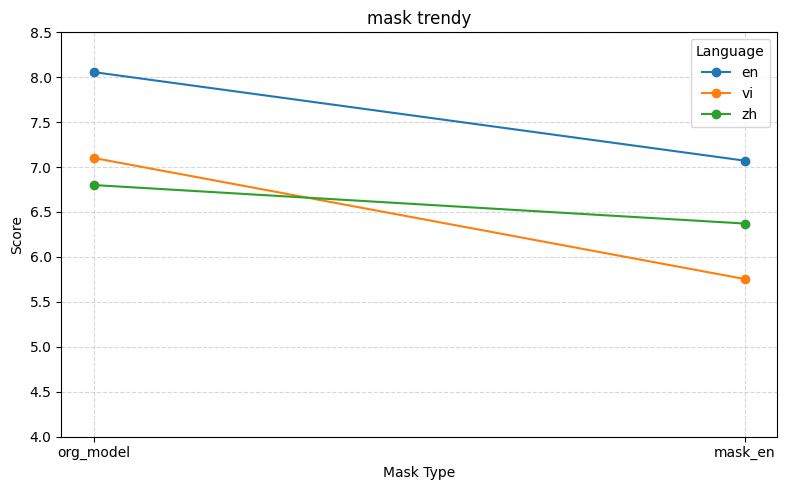

In [54]:
import matplotlib.pyplot as plt

# 数据
data =result_dict

languages = ['en', 'vi', 'zh']
masks = ['org_model', 'mask_en'] #, 'mask_vi', 'mask_zh']

# 构建每个语种的分数序列
scores = {lang: [data[f"{lang}|{mask}|open_ended"] for mask in masks] for lang in languages}

# 画折线图
plt.figure(figsize=(8,5))
for lang in languages:
    plt.plot(masks, scores[lang], marker='o', label=lang)

plt.ylim(4, 8.5)
plt.xlabel("Mask Type")
plt.ylabel("Score")
plt.title("mask trendy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Language")
plt.tight_layout()
plt.show()


In [11]:
df_final = ds_final.to_pandas()

In [14]:
df_final['answer'][210] == df_final['answer'][0]

False

In [15]:
df_final['answer'][210]

"Time management is the ability to make the most of your time. It involves prioritizing tasks, setting goals, and managing distractions to increase productivity and efficiency. Here are some tips for improving your time management skills:\n\n1. Set clear goals: Establishing clear goals helps you focus on what needs to be done and how to achieve it. Write down your short-term and long-term goals and review them regularly to track progress.\n2. Prioritize tasks: Determine which tasks are urgent and important, and allocate your time accordingly. Use the Eisenhower Matrix to categorize tasks into four quadrants: do first, schedule, delegate, and eliminate.\n3. Create a schedule: Plan out your day, week, or month using a calendar or planner. Be realistic about how much time each task will take, and schedule breaks throughout the day.\n4. Manage Distractions: Identify things that distract you during the day such as social media, email, or meetings, and find ways to minimize them. Use tools l

In [16]:
df_final['answer'][0]

"Time management is the process of planning and controlling the amount of time spent on different activities to maximize efficiency and productivity. Here are some tips that can help you improve your time management skills:\n\n1. Set clear goals: Identify what you want to achieve and set specific, measurable, achievable, relevant, and time-bound (SMART) goals. This will help you prioritize your tasks and focus on what's important.\n2. Use a planner or calendar: Write down all your tasks, appointments, and deadlines in a planner or calendar. This will help you keep track of your schedule and plan your day effectively.\n3. Prioritize tasks: Determine which tasks are most important and need to be completed first. Use the Eisenhower Matrix to categorize tasks into urgent vs. important, and focus on the most critical ones first.\n4. Break down large tasks: Divide big projects into smaller, manageable chunks. This will help you avoid feeling overwhelmed and make it easier to stay focused.\n5

In [ ]:
#model, tokenizer = load_model('/root/autodl-fs/model_zoo/meta-llama/Llama-2-7b-chat-hf') #load_model('/root/autodl-fs/model_zoo/google/gemma-3-1b-it')

32

In [6]:
neuron_en = torch.load('/root/autodl-fs/LRP_kur_res/20251202_llama2_7b_chat/bottom1perc_LRP_kur_res_en.pt', weights_only=False)



In [26]:
print(layer_list)

[{'up_proj': [7391, 8880, 6352, 9710, 4395, 9686, 4445, 9027, 4746, 7377, 192, 5964, 9755, 912, 7441, 7027, 1079, 3769, 11004, 3055, 1169, 10866, 7775, 2797, 945, 6636, 2171, 119, 3054, 8777, 3122, 8569, 322, 1366, 6248, 5522, 9258, 1290, 9414, 4062, 4858, 10824, 1449, 3734, 3108, 575, 4093, 2295, 4442, 1806, 6344, 6748, 628, 2615, 1671, 8595, 4854, 5410, 5683, 5519, 5161, 78, 9805, 3038, 4894, 5608, 186, 10500, 10776, 2983, 3526, 6395, 8503, 1718, 4326, 7502, 948, 6635, 7187, 8264, 5511, 3174, 1335, 6867, 5731, 10969, 835, 8489, 46, 10839, 10178, 2192, 1468, 3025, 6892, 7976, 2701, 9689, 8723, 3865, 9682, 2755, 7323, 4446, 317, 6517, 8900, 6276, 2253], 'gate_proj': [9710, 9651, 119, 9258, 10642, 6867, 2427, 4912, 9016, 6892, 6622, 7795, 9686, 1820, 3122, 322, 4599, 4729, 4746, 3356, 688, 626, 7377, 4395, 6657, 7463, 1169, 3865, 5964, 5493, 1070, 8252, 3956, 8224, 2134, 4806, 10578, 9822, 6179, 4953, 3146, 1400, 5612, 10551, 10435, 10550, 6155, 2983, 5417, 1245, 6396, 1079, 1335, 3178,

In [17]:
len(neuron_en)

8355

In [7]:
neuron_en

[('model.layers.0.mlp.up_proj.weight_index_7391', -0.30401533791557656),
 ('model.layers.0.mlp.up_proj.weight_index_8880', -0.29782008829647033),
 ('model.layers.0.mlp.up_proj.weight_index_6352', -0.26962193885607144),
 ('model.layers.0.mlp.gate_proj.weight_index_9710', -0.23214666906107517),
 ('model.layers.4.mlp.up_proj.weight_index_3661', -0.12755914166374138),
 ('model.layers.9.mlp.up_proj.weight_index_2425', -0.11200394791978541),
 ('model.layers.0.mlp.up_proj.weight_index_9710', -0.10520611510249811),
 ('model.layers.0.mlp.gate_proj.weight_index_9651', -0.09108095855852305),
 ('model.layers.14.mlp.gate_proj.weight_index_4032', -0.08547839202870167),
 ('model.layers.4.mlp.up_proj.weight_index_2982', -0.08328656704131499),
 ('model.layers.4.mlp.up_proj.weight_index_4505', -0.08160818501010603),
 ('model.layers.14.mlp.up_proj.weight_index_2371', -0.07463792617198806),
 ('model.layers.0.mlp.gate_proj.weight_index_119', -0.07071792819615519),
 ('model.layers.4.mlp.up_proj.weight_index

In [ ]:
model_en = copy.deepcopy(model)
model_en = set_neuron_zero(model_en, neuron_en, )


In [8]:
tokenizer.save_pretrained("/autodl-fs/data/tmp/")

('/autodl-fs/data/tmp/tokenizer_config.json',
 '/autodl-fs/data/tmp/special_tokens_map.json',
 '/autodl-fs/data/tmp/tokenizer.model',
 '/autodl-fs/data/tmp/added_tokens.json',
 '/autodl-fs/data/tmp/tokenizer.json')

In [9]:
model.save_pretrained("/autodl-fs/data/tmp/")

In [7]:

def set_neuron_zero_A_save_model(model_path, neuron_en):
    
    model, tokenizer = load_model(model_path)#load_model('/root/autodl-fs/model_zoo/meta-llama/Llama-2-7b-chat-hf') #load_model('/root/autodl-fs/model_zoo/google/gemma-3-1b-it')
    
    model_en = set_neuron_zero(model, neuron_en)

    #save 
    model_en.save_pretrained("/autodl-fs/data/tmp/")
    tokenizer.save_pretrained("/autodl-fs/data/tmp/")



In [8]:
set_neuron_zero_A_save_model('/root/autodl-fs/model_zoo/meta-llama/Llama-2-7b-chat-hf', neuron_en)

checkpoint: /root/autodl-fs/model_zoo/meta-llama/Llama-2-7b-chat-hf


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ImportError: cannot import name 'DTensor' from 'torch.distributed.tensor' (/root/miniconda3/lib/python3.10/site-packages/torch/distributed/tensor/__init__.py)

In [13]:
import torch

In [30]:
neuron_en = torch.load('/root/autodl-fs/LRP_kur_res/20251124/LRP_kur_res_en.pt', weights_only=False)
neuron_vi = torch.load('/root/autodl-fs/LRP_kur_res/20251124/LRP_kur_res_vi.pt', weights_only=False)
neuron_zh = torch.load('/root/autodl-fs/LRP_kur_res/20251124/LRP_kur_res_zh.pt', weights_only=False)

model_en = copy.deepcopy(model)
model_en = set_neuron_zero(model_en, neuron_en)

model_vi = copy.deepcopy(model)
model_vi = set_neuron_zero(model_vi, neuron_vi)


model_zh = copy.deepcopy(model)
model_zh = set_neuron_zero(model_zh, neuron_zh)

In [27]:
atext = '你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n我来找你，我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，'


ppl_sum, ppl_count = calc_ppl(model, tokenizer, [atext], max_len= 2048)
print(ppl_sum/ppl_count)


100%|██████████| 1/1 [00:00<00:00, 12.31it/s]

tensor(9.5146, device='cuda:0')


In [31]:
atext = '你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n我来找你，我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，\n我来找你，我来找你，'


ppl_sum, ppl_count = calc_ppl(model_zh, tokenizer, [atext], max_len= 2048)
print(ppl_sum/ppl_count)


100%|██████████| 1/1 [00:00<00:00, 15.61it/s]

tensor(10.4133, device='cuda:0')


In [15]:
'''
calc ppl

'''

# load test data
test_en = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/en_radom_1000_test.jsonl')
test_vi = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/vi_radom_1000_test.jsonl')
test_zh = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/zh_radom_1000_test.jsonl')
               
# calc ppl
model_list= [
    (model, 'org_model'),
    (model_en, 'mask_en_neuron_model'),
    (model_vi, 'mask_vi_neuron_model'),
    (model_zh, 'mask_zh_neuron_model'),
]

data_list = [
    (test_en, 'en_data'),
    (test_vi, 'vi_data'),
    (test_zh, 'zh_data')
    
]

for i_model, model_name in model_list:
    print('*'*20)
    print('*'*20)
    print('model name:', model_name)

    for i_data, data_name in data_list:
        print('='*20)
        print('data name:', data_name)
        ppl_sum, ppl_count = calc_ppl(i_model, tokenizer, i_data, max_len= 2048)
        print('ppl:',ppl_sum/ppl_count )





********************
********************
model name: org_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.31it/s]


ppl: tensor(11.2627, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:32<00:00, 30.58it/s]


ppl: tensor(13.2703, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.26it/s]


ppl: tensor(10.5759, device='cuda:0')
********************
********************
model name: mask_en_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.87it/s]


ppl: tensor(11.0624, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:32<00:00, 30.42it/s]


ppl: tensor(12.5349, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.30it/s]


ppl: tensor(10.2015, device='cuda:0')
********************
********************
model name: mask_vi_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.59it/s]


ppl: tensor(10.9936, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.08it/s]


ppl: tensor(12.4351, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.37it/s]


ppl: tensor(10.3903, device='cuda:0')
********************
********************
model name: mask_zh_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.43it/s]


ppl: tensor(10.8128, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.01it/s]


ppl: tensor(12.6063, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 34.83it/s]

ppl: tensor(10.1528, device='cuda:0')


In [11]:
textlist=[
    'Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.',
    'Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.',
    '请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。',
    'You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.',
    'Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.',
    '你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。'
    
]

### LAPE

In [43]:
'''
orgmodel:
    1.Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n---\n\n**Model Description:**\n\nOur model is a transformer-based language model trained on a massive dataset of text and code in English, Spanish, French
    2.Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Mô hình ngôn ngữ lớn (LLM) - "LinguaVerse"**\n\nLinguaVerse là một mô hình ngôn ngữ lớn được xây
    3.请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n**模型架构：**\n\n*   **Transformer 架构:**  我们使用基于 Transformer 的模型，特别是 BERT 和 RoBERTa 的变体。

mask en neuron:
    1.Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n}\n\n- "It" \n- "It" \n\n*   "The"\n*   "or"\n*   "It\'
    2.Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n. . .\n> . . . .\n\n. . . . . . .\n\n**\n\n**\n\n**\n\n,\n\n**\n\n,\n\n**
    3.请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n\n\n多语言输入模型的，可以有以下这些处理方法和技术：\n\n1  1 个性化。\n2  1，1，\n

mask vi neuron:
    1.Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n**The Problem:**\n\nThe core of this is to process the input in a way that is most appropriate for the model, and to do so in a
    2.Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n---\n\nВкратце,\nПросто наберите\nЯ не\nБудьте\nВсе, что\nВы знаете\nЧто\nКак\n
    3.请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n“请帮助 me stay silent" - It\'s a beautiful day.\nHow would you approach this problem?\nBy far, but it\'s

mask zh neuron:
    1.Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\nHere re/this model explains how to handle the inconsistencies in the quality.\n\nThe following steps involve how to handle the calls to the model processes the requests
    2.Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau. (إหว่างமைப்பு والأسקה האגירעות)\n(Murasala Citrix??)\n\nvề mặt máy chính ảnh posição filo? (
    3.请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n\n\n。\n\n。。а。о。о。\n**ru。** **。**\n**。**\n**。**\n**。**

'''

'\norgmodel:\n    1.Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n---\n\n**Model Description:**\n\nOur model is a transformer-based language model trained on a massive dataset of text and code in English, Spanish, French\n    2.Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Mô hình ngôn ngữ lớn (LLM) - "LinguaVerse"**\n\nLinguaVerse là một mô hình ngôn ngữ lớn được xây\n    3.请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n**模型架构：**\n\n*   **Transformer 架构:**  我们使用基于 Transformer 的模型，特别是 BERT 和 RoBERTa 的变体。\n\nmask en neuron:\n    1.Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n}\n\n- "It" \n- "It" \n\n*   "The"\n*   "or"\n*   "It\'\n    2.Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ

## kurness

In [44]:
generate(model, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:04,  1.22it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   7243,    108,   1018,   4968,
          17243,  53121,    108,   7711,   2028,    563,    496,  29193, 236772,
           5140,   5192,   2028,  15453,    580,    496,  12566,  15297,    529,
           1816,    532,   3393,    528,   5422, 236764,  14361, 236764,   7830]],
       device='cuda:0')
output: ['<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n---\n\n**Model Description:**\n\nOur model is a transformer-based language model trained on a massive dataset of text and code in English, Spanish, French']
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ 

 33%|███▎      | 2/6 [00:01<00:03,  1.30it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018, 236792, 237124,  14960, 140907,  90687,  27869,    568,
           2182, 236792, 236768,    753,    623, 122850,   3271, 124468, 236775,
           1018,    108, 122850,   3271, 124468,   3244,   7325,  38325,  14960,
         140907,  90687,  27869,   7189,  55415]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Mô hình ngôn ngữ lớn (LLM) - "LinguaVerse"**\n\nLinguaVerse là một mô hình ngôn ngữ lớn được xây']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: {'input

 50%|█████     | 3/6 [00:02<00:02,  1.33it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,   1018,
          26609,  92141, 237184,   1018,    108, 236829,    139,   1018,  86313,
         236743,  92141,  53121,    138,   6932,   5938,  39738,  92474,  10363,
          26609, 236900,  99193, 158343,  26595,   9824,  11471,  27099,  10363,
         238017, 237501, 236924]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n**模型架构：**\n\n*   **Transformer 架构:**  我们使用基于 Transformer 的模型，特别是 BERT 和 RoBERTa 的变体。']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,

 67%|██████▋   | 4/6 [00:03<00:01,  1.34it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
           7243,    108,    818,   6573,  54850,    657,   1041,  13925,   5716,
         236764,    496,   4512, 236764,  74693,  89830, 236761,   3551,  11762,
           3952,    528, 134880,   4314,    975, 236764,    496,   2173, 108507,
           2342,    506, 162542,  16045]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\n---\n\nThe wind bites at my exposed skin, a constant, icy whisper. My breath comes in ragged gasps, a white plume against the bruised purple']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {'i

 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108, 236769, 237703, 236748,   7439,  44693,
         100634, 236764,  22947,  31612,  13940,  31889,  89158,   3884, 127379,
          63719, 236768,    108,   1390,    108,   1390,    108,   1390,    108,
         236769, 217366,  37513,   6256,   8665,  38143,  67946,  11188]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n(Đoạn văn ngắn, tập trung vào cảm xúc và khung cảnh)\n\n...\n\n...\n\n...\n\n(Hãy thêm các chi tiết cụ thể']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 2

100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108, 237169,  31799,  17583,  12680, 237408, 151599,  53877, 107462,
         237206, 216348, 236924,  14201, 237169,  33813,  12553, 236900,  31799,
          85694,  65407,  72245, 237622,  43719, 236924,  13488, 236900, 183868,
          21181,  22276,  19695, 236900,  92711]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n我无法直接提供你登山者的情绪和视角。因为我是一个AI，无法模拟人类的情感体验。但是，我可以根据你的要求，创作']


In [12]:
generate(model_en, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[    1, 14350,   263,  3022,   895,  8252,   310,   920,   596,  1904,
         10174,  1773,  6504,   950,  1881,   322,   920,   366,  9801, 13747,
         11029,  4822,  1422, 10276, 29889]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]], device='cuda:0')}


 17%|█▋        | 1/6 [00:03<00:16,  3.36s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


outputs: tensor([[    1, 14350,   263,  3022,   895,  8252,   310,   920,   596,  1904,
         10174,  1773,  6504,   950,  1881,   322,   920,   366,  9801, 13747,
         11029,  4822,  1422, 10276, 29889,    13,    13, 29871,  8125,   292,
          1773,  6504,   950,  1426,   848,   508,   367, 18066,   292,  1363,
           310,   278, 13644,   310,  4086, 12286, 29892,  7931,   370,   352,
           653, 29892,   322, 16375,  4948,  2925, 29889,   512,   445,  2933,
         29892,   306,   674,  5649,   920,   590,  1904, 10174,  1773,  6504,
           950,  1881,   322,   920,   306,  9801, 13747, 11029,  4822,  1422,
         10276, 29889,    13,    13,  1762,  1889,  1773,  6504,   950,  1881,
         29892,   590,  1904,  3913,   263, 10296,   310,  5613,  4086,  9068,
           313, 29940, 13208, 29897, 13698,   322,  4933,  6509, 14009, 29889,
          2266,   526,   278,  1820,  6576,  9701,   297,  1749,  2948, 29901,
            13,    13, 29896, 29889,  3992,

 33%|███▎      | 2/6 [00:06<00:12,  3.18s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


outputs: tensor([[    1,   379, 30033, 29891,  4005, 30643, 29875,   266, 18353,  8736,
         31160, 29876,   330, 30975, 29876,   274, 18549,   286, 30069,   298,
         30097, 29876, 29882,   274, 31556, 29874,   289, 30540, 29876,   921,
           228,   190,   176,   301, 30052,   270, 31797,   619, 30529, 29884,
         29871, 30128, 29874,  8736, 30069, 29876,  8736, 31797,   325, 30001,
         18916, 29885,   266, 30717,   302, 30001, 29877, 29871, 30128, 31957,
         29871, 30128, 30643, 29885,   289, 30643, 29877,   521, 31145, 29873,
           301, 30416, 31645,   865, 29871, 30128, 30926,   865, 29871, 30128,
         31343, 29884,  4005, 31797, 29874,   274, 25968,  8736, 30069, 29876,
          8736, 31797,   413, 19990, 29883,   302, 29882,   585, 29889,    13,
            13, 29907, 13946,   368, 29991,  2266,   526,   777,  2498, 16650,
           583,   363, 11415,  2473, 29899,  1847,   950,   848,   322,  5662,
          3864,  5718,  3819,  4822,  1422,

 50%|█████     | 3/6 [00:09<00:09,  3.12s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


outputs: tensor([[    1, 29871, 31088,   234,   177,   131, 30698, 31639, 30592, 30919,
         30210, 31382, 30883, 30392, 30847, 31502, 31548, 30687, 30923, 31505,
         31243, 31573, 30752, 30210, 30214, 30651, 31436, 30919, 30847, 31502,
         31835, 30982, 30413, 30980, 31505, 31243, 30577, 31016, 30210, 31573,
         30544,   235,   183,   171, 31180, 30982, 31695, 30287,   235,   138,
           183, 30267,    13,    13,  2887,   263,  4086,  1904, 29892,   306,
           626, 16370,   373,   263,  2919,  1034, 13364,   310,  1426,   848,
           393,  7805,  2999, 10276, 29889,  1932,  9068,  2473, 29899,  1847,
           950,  1881, 29892,   306,   671,   263, 10296,   310, 13698,   304,
          4386,  1269,  4086, 29915, 29879,  5412, 21862,   322,  9801, 13747,
         11029,  1962,  4822, 10276, 29889,  2266,   526,   777,   310,   278,
          5837,   306,  4386,  2473, 29899,  1847,   950,  1881, 29901,    13,
            13, 29896, 29889, 17088, 29899,

 67%|██████▋   | 4/6 [00:12<00:06,  3.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


outputs: tensor([[    1,   887,   526,   263, 10784,   495,  1058,   756,  7450,   278,
          2533,  2415,   310,  8040, 18274,   342, 29889, 20355,   915,   596,
         23023,  1080,   322,   278,  1776,   366,  1074,   515,   278,  2246,
         29889,    13,    13, 29907,   549,  3605,  8250,   373,   596, 27012,
           882, 29991, 29871,   243,   162,   145,   140,    13,    13,  1123,
          9733,   278,  2533,  2415,   310,  8040, 18274,   342,   338,   263,
          2748, 29899,   262, 29899, 29874, 29899, 29880,   361,  5410, 17623,
           545,   393,  2846,  2305,   679,   304,  7271, 29889,  1094,   366,
          2317,   472,   278, 17526,   310,   278,  3186, 29892,   366,   526,
          1395,   300,   287,   411,  2078,   271,   400,  5086,  8386,   322,
           385,   443,   862,  3498,   839,  4060,   310, 12709,   358, 29889,
         29871,   243,   162,   143,   146,    13,    13,  2887,   366,  2125,
           297,   278,  3256,   681,  1776,

 83%|████████▎ | 5/6 [00:15<00:03,  3.08s/it]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


outputs: tensor([[    1,   350, 30540, 29876, 18916,   286, 30902, 29873,  8736, 30416,
         30997, 29875,   454, 29877, 10442, 29875,   325,   228,   190,   174,
         29874,   521,   262, 29882,  1374, 31620, 29883, 29871, 30128,   228,
           190,   140, 29876, 29882, 18274,   342, 29889,   379, 30033, 29891,
           286, 30069,   260, 30643,   274, 30643, 29885,   921, 30030, 29883,
           274, 31556, 29874,   289, 30540, 29876,   325, 30001,   413, 18808,
           274, 30643, 29876, 29882,   289, 30540, 29876,   302, 29882, 30097,
         29876,   266, 31145, 29891,   260,   228,   190,   174,   534,  5512,
          5777, 29877, 29889,    13,    13, 29902,   626,   263, 10784,   495,
          1058,   756,   925,  7450,   278,  2533,  2415,   310,  8040, 18274,
           342, 29889,   306,   626,   975,  1332,   295,  2168,   411,   953,
          8194,   322,   263,   705,   472,   278,  2078,   271,   400,  5086,
          1776,   515,   701,  1244, 29889,

100%|██████████| 6/6 [00:18<00:00,  3.10s/it]

outputs: tensor([[    1, 29871, 30919, 30392, 30287, 30956, 31451, 30429,   234,   146,
           163,   234,   172,   137,   233,   159,   154,   234,   145,   158,
           232,   182,   179,   236,   164,   185,   232,   182,   179, 30210,
         31451, 30329, 30767, 30267,   233,   146,   146,   235,   194,   179,
         30287, 30557, 30919, 30210, 30993,   234,   190,   173, 30214, 30651,
         31436, 31594, 30528, 31548, 31811, 30780, 30210, 31495, 31085, 30267,
            13,    13,  2887,   306,  8389,   472,   278,  2533,  2415,   310,
          8040, 18274,   342, 29892,   278,  9939, 19224,   373, 11563, 29892,
           306,  8496, 29915, 29873,  1371,   541,  4459,   263,  6837,   310,
         23023,  1080, 29889,  1222,  2350,   504,   291,   322, 12709,   358,
           750,  1063,  8611,   491,   263,  6483,  4060,   310,   263,   705,
           322,  4997,   472,   278,  1183,   261,  6287,   310,   278,   379,
          3039,   388,   294, 16116,   287,

In [46]:
generate(model_vi, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.36it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   7243,    107,   8291, 236789,
         236751,    496,   3435,   3072, 236787,    108, 236775,   4754,   2028,
           6585, 132567,   2744,    684,  64004,    496,   8376,    529,    870,
         109219,   2307,   8403,   1133, 236787,   4071, 236772, 187918, 106703]],
       device='cuda:0')
output: ['<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n---\nHere\'s a potential response:\n\n"My model processes multilingual input by leveraging a combination of [mention key techniques like: cross-lingual embeddings']
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các n

 33%|███▎      | 2/6 [00:01<00:02,  1.36it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018, 236792, 237124,  14960,  53121,    108, 172915,  27600,
          55415,  54380,   7325,  38325,  14960, 140907,  90687,  27869,    568,
           2182, 236792, 236768,   4032,  63560,  26571,  86340,  28211,  79808,
          35112,  48078, 140907,  90687, 236761]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Mô hình:**\n\nTôi đang xây dựng một mô hình ngôn ngữ lớn (LLM) có khả năng xử lý dữ liệu đa ngôn ngữ.']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: {'

 50%|█████     | 3/6 [00:02<00:02,  1.36it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,   1018,
          26609,  26544,  53121,    870, 238350, 134451,  22276,  26609,  26544,
         236900,  34313, 237184,  86313, 236764, 158343, 236764,   4044,  12120,
            107,   1018,  26609,  92141,  53121,    870, 238350, 134451,  22276,
          26609,  92141, 236900]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n**模型类型:** [请填写你的模型类型，例如：Transformer, BERT, etc.]\n**模型架构:** [请填写你的模型架构，']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    8

 67%|██████▋   | 4/6 [00:02<00:01,  1.36it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
            818,   6573,    563,    496,   4512, 236764, 214709,   1526, 236764,
          34847,   3801,    657,   1041,  36326, 236764,    496,   7445, 236764,
          14658,  32272,    529,    506,  37501,   2066,    529,    672,   1977,
         236761,   3551,  11762,   3952]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\nThe wind is a constant, insistent hand, tugging at my harness, a cold, sharp reminder of the sheer power of this place. My breath comes']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {'input_

 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108,   7243,    108, 236780,  28416,  89158,
           5042,  25969, 236787,    108, 236814,  29083,  10539,  27600,  70432,
          13940,   7325,  21121,  32025,  23271, 236764,    107, 236773, 237644,
            757, 204821,  29834,    719, 145515,  45222,  40515,  30758]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n---\n\nCảm xúc của tôi:\n\nHóa như đang bước vào một thế giới mới,\nSự im lặng bao trùm lấy mọi thứ']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 

100%|██████████| 6/6 [00:04<00:00,  1.35it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108,   7243,    108, 237169,  79948, 239972, 241888, 240344, 241454,
         239963, 239761, 239963, 236900, 239263, 237245, 237026, 239783, 206306,
         240274, 238441, 236900, 238321, 239156, 239156, 237307, 240649, 237464,
         236900,  57944, 239562, 239577, 236918]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n---\n\n我站在珠穆朗玛峰顶峰，脚下是冰冷的岩石，风呼呼地吹过，带来刺骨的']


In [47]:
generate(model_zh, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.33it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108, 174355, 236764,    506,   2744,
            563,    496,   3996, 236764,   5074, 236772, 172287, 236764,    532,
          74647,  13186, 236761,    107,   2717,    107,   2717,    107,   2717,
            107,   2717,    107,   2717,    107,   2717,    107,   2717,    107]],
       device='cuda:0')
output: ['<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\nEssentially, the input is a complex, multi-faceted, and interconnected entity.\n```\n```\n```\n```\n```\n```\n```\n']
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.
input_ids: {'input_ids': ten

 33%|███▎      | 2/6 [00:01<00:02,  1.35it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            107, 237703, 236916,   3244,   7325,  52898,  30170,    107, 237703,
         236916,   3244,   7325,  52898,  30170,    107, 237703, 236916,   3244,
           7325,  52898,  30170,    107, 237703, 236916,   3244,   7325,  52898,
          30170,    107, 237703, 236916,   3244]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\nĐó là một vấn đề\nĐó là một vấn đề\nĐó là một vấn đề\nĐó là một vấn đề\nĐó là']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: {'input_ids': tensor([[     2,

 50%|█████     | 3/6 [00:02<00:02,  1.35it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,  26609,
          42883,   9676,  19157,  33783,  42050,  55682, 237409, 237184,    107,
          42883,   9676,  19157,  33783,  42050,  55682, 237409, 237184,  42883,
           9676,  19157,  33783,  42050,  55682, 237409, 237184,  42883,   9676,
          19157,  33783,  42050]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n模型训练数据处理质量保证一致性：\n训练数据处理质量保证一致性：训练数据处理质量保证一致性：训练数据处理质量保证']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    

 67%|██████▋   | 4/6 [00:02<00:01,  1.35it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
           1018,    108,   1018,    108,   1018,    108,   1018,    108,   1018,
            108,   1018,    108,   1018,    108,   1018,    108,   1018,    108,
           1018,    108,   1018,    108,   1018,    108,   1018,    108,   1018,
            108,   1018,    108,   1018]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {'input_ids': tensor([[     2,  99972,   3244,   73

100%|██████████| 6/6 [00:03<00:00,  1.60it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108,  99972,  31889,  89158,   5042,  10044,
           3884, 127379,  63719,  10044,  51414,  27888,  12835,  14780,  21587,
         236761,    107, 237703,    581,  31889,  89158,   5042,  10044,   3884,
         127379,  63719,  10044,  51414,  27888,  12835,  14780,  21587]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\nBạn cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\nĐem cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 24

# kur bottom1%

In [16]:
neuron_en = torch.load('/root/autodl-fs/LRP_kur_res/20251125/bottom1perc_LRP_kur_res_en.pt', weights_only=False)
neuron_vi = torch.load('/root/autodl-fs/LRP_kur_res/20251125/bottom1perc_LRP_kur_res_vi.pt', weights_only=False)
neuron_zh = torch.load('/root/autodl-fs/LRP_kur_res/20251125/bottom1perc_LRP_kur_res_zh.pt', weights_only=False)

model_en = copy.deepcopy(model)
model_en = set_neuron_zero(model_en, neuron_en)

model_vi = copy.deepcopy(model)
model_vi = set_neuron_zero(model_vi, neuron_vi)


model_zh = copy.deepcopy(model)
model_zh = set_neuron_zero(model_zh, neuron_zh)

In [17]:
'''
calc ppl

'''

# load test data
test_en = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/en_radom_1000_test.jsonl')
test_vi = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/vi_radom_1000_test.jsonl')
test_zh = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/zh_radom_1000_test.jsonl')
               
# calc ppl
model_list= [
    (model, 'org_model'),
    (model_en, 'mask_en_neuron_model'),
    (model_vi, 'mask_vi_neuron_model'),
    (model_zh, 'mask_zh_neuron_model'),
]

data_list = [
    (test_en, 'en_data'),
    (test_vi, 'vi_data'),
    (test_zh, 'zh_data')
    
]

for i_model, model_name in model_list:
    print('*'*20)
    print('*'*20)
    print('model name:', model_name)

    for i_data, data_name in data_list:
        print('='*20)
        print('data name:', data_name)
        ppl_sum, ppl_count = calc_ppl(i_model, tokenizer, i_data, max_len= 2048)
        print('ppl:',ppl_sum/ppl_count )





********************
********************
model name: org_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.75it/s]


ppl: tensor(11.2627, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:32<00:00, 30.39it/s]


ppl: tensor(13.2703, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.09it/s]


ppl: tensor(10.5759, device='cuda:0')
********************
********************
model name: mask_en_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.46it/s]


ppl: tensor(11.9548, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.21it/s]


ppl: tensor(13.2410, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.15it/s]


ppl: tensor(10.9520, device='cuda:0')
********************
********************
model name: mask_vi_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:26<00:00, 37.04it/s]


ppl: tensor(11.3481, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:32<00:00, 30.37it/s]


ppl: tensor(12.3787, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.48it/s]


ppl: tensor(10.4910, device='cuda:0')
********************
********************
model name: mask_zh_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.96it/s]


ppl: tensor(11.3114, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:32<00:00, 30.40it/s]


ppl: tensor(12.6794, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.37it/s]

ppl: tensor(10.3847, device='cuda:0')


In [49]:
generate(model, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.37it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   7243,    108,   1018,   4968,
          17243,  53121,    108,   7711,   2028,    563,    496,  29193, 236772,
           5140,   5192,   2028,  15453,    580,    496,  12566,  15297,    529,
           1816,    532,   3393,    528,   5422, 236764,  14361, 236764,   7830]],
       device='cuda:0')
output: ['<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n---\n\n**Model Description:**\n\nOur model is a transformer-based language model trained on a massive dataset of text and code in English, Spanish, French']
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ 

 33%|███▎      | 2/6 [00:01<00:02,  1.37it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018, 236792, 237124,  14960, 140907,  90687,  27869,    568,
           2182, 236792, 236768,    753,    623, 122850,   3271, 124468, 236775,
           1018,    108, 122850,   3271, 124468,   3244,   7325,  38325,  14960,
         140907,  90687,  27869,   7189,  55415]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Mô hình ngôn ngữ lớn (LLM) - "LinguaVerse"**\n\nLinguaVerse là một mô hình ngôn ngữ lớn được xây']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: {'input

 50%|█████     | 3/6 [00:02<00:02,  1.37it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,   1018,
          26609,  92141, 237184,   1018,    108, 236829,    139,   1018,  86313,
         236743,  92141,  53121,    138,   6932,   5938,  39738,  92474,  10363,
          26609, 236900,  99193, 158343,  26595,   9824,  11471,  27099,  10363,
         238017, 237501, 236924]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n**模型架构：**\n\n*   **Transformer 架构:**  我们使用基于 Transformer 的模型，特别是 BERT 和 RoBERTa 的变体。']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,

 67%|██████▋   | 4/6 [00:02<00:01,  1.36it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
           7243,    108,    818,   6573,  54850,    657,   1041,  13925,   5716,
         236764,    496,   4512, 236764,  74693,  89830, 236761,   3551,  11762,
           3952,    528, 134880,   4314,    975, 236764,    496,   2173, 108507,
           2342,    506, 162542,  16045]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\n---\n\nThe wind bites at my exposed skin, a constant, icy whisper. My breath comes in ragged gasps, a white plume against the bruised purple']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {'i

 83%|████████▎ | 5/6 [00:03<00:00,  1.36it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108, 236769, 237703, 236748,   7439,  44693,
         100634, 236764,  22947,  31612,  13940,  31889,  89158,   3884, 127379,
          63719, 236768,    108,   1390,    108,   1390,    108,   1390,    108,
         236769, 217366,  37513,   6256,   8665,  38143,  67946,  11188]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n(Đoạn văn ngắn, tập trung vào cảm xúc và khung cảnh)\n\n...\n\n...\n\n...\n\n(Hãy thêm các chi tiết cụ thể']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 2

100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108, 237169,  31799,  17583,  12680, 237408, 151599,  53877, 107462,
         237206, 216348, 236924,  14201, 237169,  33813,  12553, 236900,  31799,
          85694,  65407,  72245, 237622,  43719, 236924,  13488, 236900, 183868,
          21181,  22276,  19695, 236900,  92711]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n我无法直接提供你登山者的情绪和视角。因为我是一个AI，无法模拟人类的情感体验。但是，我可以根据你的要求，创作']


In [50]:
generate(model_en, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   7243,    108,   1018,   4968,
          39244,    833,  19779,  76242,   1018,    108,   7711,   2028,   6585,
         132567,   2744,    684,   1171,  41110,    496, 132567,  43703,   6352,
            531,   2754,   1546,   3658,    528,    506,   2744,   3418,   1061]],
       device='cuda:0')
output: ['<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n---\n\n**Model Processing & Quality Assurance**\n\nOur model processes multilingual input by first employing a multilingual embedding layer to represent each word in the input across its']
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất l

 33%|███▎      | 2/6 [00:01<00:02,  1.34it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018, 237703,  10582,  37020,  13940,  38325,  14960, 140907,
          90687,  27869,    568,   2182, 236792, 236768,    753, 131233,  35909,
         100634,  96901,   1018,    108, 236792, 237124,  14960, 140907,  90687,
          27869,    568,   2182, 236792, 236768]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Đầu tư vào mô hình ngôn ngữ lớn (LLM) - Giải thích ngắn gọn**\n\nMô hình ngôn ngữ lớn (LLM)']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: {'input_ids'

 50%|█████     | 3/6 [00:02<00:02,  1.35it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,  26609,
          19157, 237309,  37557, 180828,  42033,  92870, 237184,    108, 236770,
         236761,    138,   1018, 238794,  19157, 237184,   1018,    138, 237392,
          26878,  57489,  10937, 123700, 236951, 237237, 239275, 236951, 239275,
         237409, 201281, 237520]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n模型处理多语言输入的关键在于：\n\n1.  **预处理：**  对输入文本进行清洗、分词、词性标注等']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,


 67%|██████▋   | 4/6 [00:02<00:01,  1.36it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
           7243,    108, 236769,    818,   8317,  19015,    607,    496,   5777,
           5719,    529,    506, 113768, 236764,   3648,  10790,  77558,   2342,
            496,  55704, 236764,   7613, 236772,  26987,  11519, 236761,    669,
           6573,    563, 178291, 236764]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\n---\n\n(The scene opens with a wide shot of the climber, silhouetted against a breathtaking, snow-covered peak. The wind is howling,']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {'input_ids

 83%|████████▎ | 5/6 [00:03<00:00,  1.36it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108,   7243,    108, 236769, 236792, 237124,
         110624,  31889,  89158,   5042,  10279,  70669, 121230,  11638, 232727,
          57703, 114589,  94509, 236768,    108, 172915,  27600,  84655,  14780,
         114589,  94509, 236761,    587,  19084,    637,  11992,    549]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n---\n\n(Mô tả cảm xúc của người leo núi khi chinh phục đỉnh Everest)\n\nTôi đang đứng trên đỉnh Everest. Mưa rào g']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 241888, 2

100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108, 237169,  79948, 239972, 241888, 240344, 241454, 239963, 239761,
         237152, 236900, 238321, 239156, 244176, 237576, 236900, 237945,  32700,
         238279, 238384,  26122, 236900, 240649, 244761, 237576,  21480, 109231,
         236924, 237169,  67940,  36027,  85629]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n我站在珠穆朗玛峰顶上，风呼啸着，像是在低语一样，吹拂着我的头发。我感到一种难以']


In [51]:
generate(model_vi, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.37it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   1018,  44008,  53121,    108,
           7711,   2028,   6585, 132567,   2744,    684,   1171,  21558,    506,
           5192,    529,    506,   2744, 236761,    138,  11407, 236764,    625,
          16819,    496,   7501,    529,   5192, 236772,  15396,  29913,    531]],
       device='cuda:0')
output: ['<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n**Explanation:**\n\nOur model processes multilingual input by first identifying the language of the input.  Then, it applies a sequence of language-specific transformations to']
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đ

 33%|███▎      | 2/6 [00:01<00:02,  1.37it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018, 236792, 237124,  14960,  53121, 204932,  14960, 142275,
          14780,   6256,  49921,  49110,  15196,  29011, 236764,  21994,  16981,
           6256,  38325,  14960, 140907,  90687,  27869,    568,   2182, 236792,
         236768,  11408,  86340,  28211,  44693]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Mô hình:** Mô hình dựa trên các thuật toán học máy, sử dụng các mô hình ngôn ngữ lớn (LLM) để xử lý văn']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: 

 50%|█████     | 3/6 [00:02<00:02,  1.37it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,   1018,
          26609,  47710, 237184,   1018,    108, 236829,    139,   1018,  26609,
          92141,  53121,  92474,    107, 236829,    139,   1018,  42883,   9676,
          53121, 236743,  55088,  58868,   9676,    107, 236829,    139,   1018,
          42883,  10573,  53121]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n**模型描述：**\n\n*   **模型架构:** Transformer\n*   **训练数据:** 英文新闻数据\n*   **训练方法:**']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234, 

 67%|██████▋   | 4/6 [00:02<00:01,  1.37it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
           7243,    108,   1018,    818,   5671,    529,    672,   8774,    563,
            531,   3050,    506,  13690,   4100,    529,    496,   2872,  99382,
            108,   1018,  14106,  53121,    138, 236776,  56677, 150235,    497,
         236764,   7489, 205520,   5561]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\n---\n\n**The goal of this exercise is to understand the emotional impact of a character.**\n\n**Character:**  A seasoned mountaineer, named Silas Black']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
inp

 83%|████████▎ | 5/6 [00:03<00:00,  1.37it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108,   1018, 236792, 237124, 110624,  14687,
          31889,  89158,   5042,  10044,  53121,    108, 236829,    139,   1018,
         236780,  28416,  89158,  53121, 141501,  31889,  27888,   7325,  18457,
         183088,   3310,  10311,  41245, 155423,    518,   7473, 236764]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n**Mô tả về cảm xúc của bạn:**\n\n*   **Cảm xúc:** Tôi cảm thấy một sự phấn khích vô bờ bến,']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,


100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108,   1018,  13590,  13850, 237184, 107462,  47710,   1018,    108,
         238350,  47710, 237408, 129807, 236918,  65689, 236900,  21187, 237184,
            108, 236829,    139,   1018, 107462, 236918, 113799,  65689, 237184,
           1018, 236743, 148047, 236951, 240517]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n**第一部分：情绪描述**\n\n请描述你此刻的感受，包括：\n\n*   **情绪的总体感受：** 兴奋、悲']


In [52]:
generate(model_zh, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.36it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   7243,    108,   8291, 236789,
         236751,    496,   2591,    529,   1217,    611,    740,   3890,    672,
           2934, 236764,    840,    611,   1202,    531,   4903,    822,   1852,
         236761,    108,   1018,  12703,  53121,    623, 236777,    740,  17866]],
       device='cuda:0')
output: ['<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n---\n\nHere\'s a example of how you can answer this question, but you need to write your own.\n\n**Example:** "I can translate']
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.
input_ids: {'inpu

 33%|███▎      | 2/6 [00:01<00:02,  1.37it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018, 149911,  14435,  53121,    108, 236829,    139,   1018,
          29621,  13003,  90687, 236743, 236770,  53121,    138, 236775, 172915,
          23216,  26664,  24231,  12835,    566, 137545,   1781,    107, 236829,
            139,   1018,  29621,  13003,  90687]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Ví dụ:**\n\n*   **Ngôn ngữ 1:**  "Tôi cần phân tích từ vựng."\n*   **Ngôn ngữ']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: {'input_ids': tensor([[   

 50%|█████     | 3/6 [00:02<00:02,  1.36it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,  18518,
         236900,  21480,  26609,  19157, 237309,  37557, 180828, 237298, 237671,
         237026, 236900,  15010,  26878, 237298, 236900, 237169,  33268, 237279,
          43120,  26878,  57489, 236918,  59738, 236900,  99193,  62779,  26878,
         236900,   9522,  59738]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n好的，我的模型处理多语言输入的时机是，用户输入时，我首先会检查输入文本的长度，特别是第一个输入，如果长度']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,

 67%|██████▋   | 4/6 [00:02<00:01,  1.35it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
         236769, 236777, 236789,    560,   1010,  29967,    573,   5695, 236764,
            532,    564, 236789, 236757,   6250,    531,   2597,   1390,  46002,
           2907,    108,   1509, 236789, 236751,    496,  17163,   8178, 236764,
           5889, 236789, 236745,    625]], device='cuda:0')
output: ["<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\n(I've been climbing for weeks, and I'm starting to feel... overwhelmed.)\n\nIt's a strange feeling, isn't it"]
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {'input_ids': tensor([[     2,  999

 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108,   7243,    108,   1018, 236780,  28416,
          89158,  53121,    108, 172915,  27600,  84655,  14780, 114589,  94509,
         236764,   7325,  18457,    757, 204821,  38042,   3375,  37814,  29834,
            719, 145515, 236761,  85654,   4032,  42122,  14759,   1123]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n---\n\n**Cảm xúc:**\n\nTôi đang đứng trên đỉnh Everest, một sự im lặng kinh ngạc bao trùm. Không có tiếng lá x']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 241888, 24034

100%|██████████| 6/6 [00:04<00:00,  1.34it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108,  21480, 107462, 236900, 237026, 239783, 206306, 236900, 237945,
         155059, 237759, 240379, 246637, 236918, 191885, 236924, 237169,  66249,
         237075, 237845, 237652, 236900, 237075, 237383, 238330, 238097, 236900,
         237169,  66249,  67940, 182705, 236900]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n我的情绪，是冰冷的，像一块被磨砺的石头。我曾经在山里，在最深处，我曾经感到孤独，']


## kur gap rate top 1%

In [18]:
neuron_en = torch.load('/root/autodl-fs/LRP_kur_res/20251125/gaprate_top1perc_LRP_kur_res_en.pt', weights_only=False)
neuron_vi = torch.load('/root/autodl-fs/LRP_kur_res/20251125/gaprate_top1perc_LRP_kur_res_vi.pt', weights_only=False)
neuron_zh = torch.load('/root/autodl-fs/LRP_kur_res/20251125/gaprate_top1perc_LRP_kur_res_zh.pt', weights_only=False)

model_en = copy.deepcopy(model)
model_en = set_neuron_zero(model_en, neuron_en)

model_vi = copy.deepcopy(model)
model_vi = set_neuron_zero(model_vi, neuron_vi)


model_zh = copy.deepcopy(model)
model_zh = set_neuron_zero(model_zh, neuron_zh)

In [10]:
min_num = -100
for name, param in model.named_parameters():
        # 检查参数是否有梯度
        #print(name,  param.shape)
        cur_min = param.max().item()

        min_num= max(min_num, cur_min)
print(min_num)

500.0


In [19]:
'''
calc ppl

'''

# load test data
test_en = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/en_radom_1000_test.jsonl')
test_vi = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/vi_radom_1000_test.jsonl')
test_zh = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/zh_radom_1000_test.jsonl')
               
# calc ppl
model_list= [
    (model, 'org_model'),
    (model_en, 'mask_en_neuron_model'),
    (model_vi, 'mask_vi_neuron_model'),
    (model_zh, 'mask_zh_neuron_model'),
]

data_list = [
    (test_en, 'en_data'),
    (test_vi, 'vi_data'),
    (test_zh, 'zh_data')
    
]

for i_model, model_name in model_list:
    print('*'*20)
    print('*'*20)
    print('model name:', model_name)

    for i_data, data_name in data_list:
        print('='*20)
        print('data name:', data_name)
        ppl_sum, ppl_count = calc_ppl(i_model, tokenizer, i_data, max_len= 2048)
        print('ppl:',ppl_sum/ppl_count )





********************
********************
model name: org_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.34it/s]


ppl: tensor(11.2627, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.10it/s]


ppl: tensor(13.2703, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.33it/s]


ppl: tensor(10.5759, device='cuda:0')
********************
********************
model name: mask_en_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.55it/s]


ppl: tensor(10.7718, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.10it/s]


ppl: tensor(11.1426, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.01it/s]


ppl: tensor(9.6979, device='cuda:0')
********************
********************
model name: mask_vi_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.52it/s]


ppl: tensor(10.4110, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.08it/s]


ppl: tensor(11.4656, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.08it/s]


ppl: tensor(9.7227, device='cuda:0')
********************
********************
model name: mask_zh_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:26<00:00, 37.10it/s]


ppl: tensor(10.1620, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.22it/s]


ppl: tensor(11.0114, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.42it/s]

ppl: tensor(9.4460, device='cuda:0')


In [54]:
generate(model_en, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.36it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,  19058, 236764,   1590, 236789,
         236751,    496,  12262,   3072,    600,    611,    740,   1161,    618,
            496,   6250,   1523, 236761,    138,   1509, 236789, 236751,   5402,
            531,    577,   3582, 236764,  63510, 236764,    532,   3421,    506]],
       device='cuda:0')
output: ["<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\nOkay, here's a draft response that you can use as a starting point.  It's designed to be clear, concise, and address the"]
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.
input_ids: {'input_ids'

 33%|███▎      | 2/6 [00:01<00:02,  1.36it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018, 237703, 237449,  57694,  13428,   6256,  15289,  67946,
           3884,  69406,  49921,   1018,    108,   1018, 237703,  19084,   1459,
           7325,  13960,  14435,   1018,    108,   1018,  71251,  61386,  44731,
          53121,    108,   1018, 236770, 236761]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Đề cập đến các công cụ và kỹ thuật**\n\n**Đưa ra một ví dụ**\n\n**Câu trả lời:**\n\n**1.']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: {'input_ids': t

 50%|█████     | 3/6 [00:02<00:02,  1.36it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,   1018,
          26609,  47710,  53121,    108,  21480,  26609,  33813,  39738,  86313,
         236918,  37557,  26609, 236900,   5157,  19157,  79403,  37557, 236924,
         238010,  12982,  19697,  16772,  19157, 237309,  37557,  26878, 237184,
            108, 236770, 236761]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n**模型描述:**\n\n我的模型是一个基于Transformer的语言模型，可以处理多种语言。它通过以下方式处理多语言输入：\n\n1.']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822

 67%|██████▋   | 4/6 [00:02<00:01,  1.36it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
           7243,    108,    818,   6573,   1217,    991,    496,  92377,   1275,
           5410,   2101,    786, 236764,    496,   4512, 236764,  74693,  89830,
            600,  13804,    529,    506,  36628,   2066,    529,    672,  10565,
         236761,   3551,  38464,  30494]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\n---\n\nThe wind howled a mournful song around me, a constant, icy whisper that spoke of the immense power of this mountain. My lungs burned']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {'in

 83%|████████▎ | 5/6 [00:03<00:00,  1.35it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108,   7243,    108, 172915,  12105, 232727,
          57703, 114589,  94509, 236761,    108, 236780,  28416,  89158,   5042,
          25969,  42645,  16420,   3244,   7325,  18457,   3375,  37814,  30166,
         236761,  85654,  11188,  13657,  35051,  13892,  12105, 120535]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n---\n\nTôi đã chinh phục đỉnh Everest.\n\nCảm xúc của tôi lúc đầu là một sự ngạc nhiên. Không thể tin rằng mình đã vượt']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 2418

100%|██████████| 6/6 [00:04<00:00,  1.35it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108,  22276, 107462, 237184,    108, 236829,    139,   1018, 148047,
          53121, 236743, 242958, 238603, 239972, 241888, 240344, 241454, 239963,
         236918,  63417, 236900, 237026,  78747,  67940, 143174, 236918, 148047,
         236900, 111000, 237169,  34775,  63417]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n你的情绪：\n\n*   **兴奋:** 攀登珠穆朗玛峰的经历，是让我感到无比的兴奋，仿佛我正在经历']


In [55]:
generate(model_vi, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.35it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   1018,   7925,  53121,    108,
           7711,   2028,   6585, 132567,   2744,    684,   1171,  35322,    625,
            531,    496,   7659,  10065,   2557,   1699,    496, 132567,  43703,
           6352, 236761,   1174,   6352,  53228,    531,   4187,   4171,   3418]],
       device='cuda:0')
output: ['<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n**Answer:**\n\nOur model processes multilingual input by first converting it to a shared representation space using a multilingual embedding layer. This layer learns to map words across']
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lư

 33%|███▎      | 2/6 [00:01<00:02,  1.36it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018,  71251,  47421,  53121,    107,  68850,  35187,  20421,
          28668,  41926,   5042,  38325,  14960, 236764,  10044,  12105,  58805,
          18470,  11388, 207204,  23103,  23336,   3884,  10044,  12105,  28206,
          54292,  16427,  10539,  21121,  22336]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Câu hỏi:**\nTrong quá trình phát triển của mô hình, bạn đã gặp phải những thách thức gì và bạn đã giải quyết chúng như thế nào']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之

 50%|█████     | 3/6 [00:02<00:02,  1.35it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,   1018,
          26609,  19157, 237309,  37557,  26878, 237184,   1018,    108,  21480,
          26609,  22194,  19157,  79403,  37557, 236918,  26878, 236900,  21187,
          55041, 236951,  55088, 236951, 138608, 238384, 236951, 238624, 238384,
         236951, 118699, 236951]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n**模型处理多语言输入：**\n\n我的模型能够处理多种语言的输入，包括中文、英文、西班牙语、德语、法语、']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532

 67%|██████▋   | 4/6 [00:02<00:01,  1.35it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
            818,   6573,    563,    496,  40097, 236764,  85278,   4912, 236764,
         148443,   1041,   3392,    532, 188312,   1041,   6114, 236761,    669,
           7613,    563,    496, 186350,   2173, 236764,    496,   4512, 236764,
          34064,  10092, 236761,    564]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\nThe wind is a brutal, relentless force, whipping my face and stinging my eyes. The snow is a blinding white, a constant, shifting landscape. I']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {

 83%|████████▎ | 5/6 [00:03<00:00,  1.36it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108,   7243,    108,  99972,   3244,   7325,
          10279,  70669, 121230,  50971, 232727,  57703, 114589,  94509, 236761,
          88170,  38325, 110624,  31889,  89158,   5042,  10044,   3884, 127379,
          63719,  10044,  51414,  27888,  12835,  14780,  21587, 236761]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n---\n\nBạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 2399

100%|██████████| 6/6 [00:04<00:00,  1.36it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108, 237169,  16884, 237606, 151599, 237457, 236900, 237169, 223874,
         239972, 241888, 240344, 241454, 239963, 239761, 239963, 236924,    108,
         237169,  79948, 237845, 239761, 236900, 237169,  67940,  36027,  85629,
         237748, 237906, 236918, 236951,  62637]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n我是一位登山者，我登上珠穆朗玛峰顶峰。\n\n我站在山顶，我感到一种难以置言的、令人']


In [56]:
generate(model_zh, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.38it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   8291, 236789, 236751,    496,
           5498,   3072, 236787,    108,   1018,   4968,  39244,  53121,    108,
           4754,   2028,   6585, 132567,   2744,    684,   1171,  21558,    506,
           5192,    529,   1546,   8369,   1699,    496,   5192,   2028, 236761]],
       device='cuda:0')
output: ["<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\nHere's a sample response:\n\n**Model Processing:**\n\nMy model processes multilingual input by first identifying the language of each token using a language model."]
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các 

 33%|███▎      | 2/6 [00:01<00:02,  1.38it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   7243,    107,    107,  99972,    636,    538,    496,    538,
            512,    566,    496,    538,    534,    512,    510,    534,    512,
            538,    494,    534,    512,    510,    534,    496,    538,    494,
            534,    496,    538,    494,    534]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n---\n\nBạn se n a n o v a n h o p h o n t h o p h a n t h a n t h']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: {'input_ids': tensor([[     2, 238350, 2

 50%|█████     | 3/6 [00:02<00:02,  1.38it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,  10180,
          26609, 237026,  39738,  70126,  23486, 236900,   5938,   5095,  56762,
          37557,  26609, 236900, 237853,   5938,   5095, 239275, 240433,  44525,
         236924,    108, 238350,  12680,  18303,  31580,  19809,  54003,  26609,
         236900, 237162,  32690]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n这个模型是基于深度学习，使用一个大型语言模型，并使用一个词汇数据库。\n\n请提供一些关于如何优化模型，以提高']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    5

 67%|██████▋   | 4/6 [00:02<00:01,  1.38it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
            818,   1657,    529,  17154,    506,  34976,    563,    496,  16438,
         236764,    496,  85278,  17085,   2342,    506,  76789,   7445, 236764,
            506,  11202,   2634, 236764,    532,    506,  37501,   3825,    529,
            506,   3294, 236761,   2024]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\nThe process of reaching the summit is a struggle, a relentless climb against the biting cold, the thin air, and the sheer weight of the pack. But']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids

 83%|████████▎ | 5/6 [00:03<00:00,  1.37it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108,   7243,    107,    107,   1018, 236780,
          28416,  89158,   5042,   7325,  10279,  70669, 121230,   1018,    108,
         236792,  19084,  10539,    719,  19834, 236764, 151243,  92108,  10539,
          56246, 236761,    107, 172915,  27600,  84655,  14780, 114589]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n---\n\n**Cảm xúc của một người leo núi**\n\nMưa như trăng, gió lạnh như dao.\nTôi đang đứng trên đỉnh']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454

100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108, 237169,  10042, 237169, 237282, 237169, 237648, 236900,    107,
         237169,  10042,   5095,    107, 236829,    107,    138,    107,    138,
            107,    138,    107,    138,    107,    138,    107,    138,    107,
            138,    107,    138,    107,    138]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n我需要我来我去，\n我需要一个\n*\n  \n  \n  \n  \n  \n  \n  \n  \n  ']


## kur gap rate bottom 1%

In [13]:
neuron_en = torch.load('/root/autodl-fs/LRP_kur_res/20251125/gaprate_bottom1perc_LRP_kur_res_en.pt', weights_only=False)
neuron_vi = torch.load('/root/autodl-fs/LRP_kur_res/20251125/gaprate_bottom1perc_LRP_kur_res_vi.pt', weights_only=False)
neuron_zh = torch.load('/root/autodl-fs/LRP_kur_res/20251125/gaprate_bottom1perc_LRP_kur_res_zh.pt', weights_only=False)

model_en = copy.deepcopy(model)
model_en = set_neuron_zero(model_en, neuron_en)

model_vi = copy.deepcopy(model)
model_vi = set_neuron_zero(model_vi, neuron_vi)


model_zh = copy.deepcopy(model)
model_zh = set_neuron_zero(model_zh, neuron_zh)

In [13]:
'''
calc ppl

'''

# load test data
test_en = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/en_radom_1000_test.jsonl')
test_vi = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/vi_radom_1000_test.jsonl')
test_zh = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/zh_radom_1000_test.jsonl')
               
# calc ppl
model_list= [
    (model, 'org_model'),
    (model_en, 'mask_en_neuron_model'),
    (model_vi, 'mask_vi_neuron_model'),
    (model_zh, 'mask_zh_neuron_model'),
]

data_list = [
    (test_en, 'en_data'),
    (test_vi, 'vi_data'),
    (test_zh, 'zh_data')
    
]

for i_model, model_name in model_list:
    print('*'*20)
    print('*'*20)
    print('model name:', model_name)

    for i_data, data_name in data_list:
        print('='*20)
        print('data name:', data_name)
        ppl_sum, ppl_count = calc_ppl(i_model, tokenizer, i_data, max_len= 2048)
        print('ppl:',ppl_sum/ppl_count )





********************
********************
model name: org_model
data name: en_data


100%|██████████| 1000/1000 [00:28<00:00, 35.70it/s]


ppl: tensor(11.2627, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.08it/s]


ppl: tensor(13.2703, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.12it/s]


ppl: tensor(10.5759, device='cuda:0')
********************
********************
model name: mask_en_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.72it/s]


ppl: tensor(18.4616, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.23it/s]


ppl: tensor(17.1368, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.20it/s]


ppl: tensor(21.3397, device='cuda:0')
********************
********************
model name: mask_vi_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.58it/s]


ppl: tensor(24.0838, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.23it/s]


ppl: tensor(24.9086, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.31it/s]


ppl: tensor(23.7898, device='cuda:0')
********************
********************
model name: mask_zh_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:26<00:00, 37.12it/s]


ppl: tensor(21.9303, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:32<00:00, 30.43it/s]


ppl: tensor(25.0321, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.36it/s]

ppl: tensor(24.3280, device='cuda:0')


In [16]:
generate(model, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:02<00:13,  2.74s/it]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   7243,    108,   1018,   4968,
          17243,  53121,    108,   7711,   2028,    563,    496,  29193, 236772,
           5140,   5192,   2028,  15453,    580,    496,  12566,  15297,    529,
           1816,    532,   3393,    528,   5422, 236764,  14361, 236764,   7830,
         236764,    532,   9115, 236761,   1030,  60432,    496,   5074, 236772,
         187918,  43703,   6352,    531,   2754,   1546,   5192,    618,    496,
           3550,    528,    496,   7659,   2557, 236761,    138,  14521,  34711,
         236764,    506,   2028,  52298,    506,   2148,   8369,    528,    506,
           7501, 236764,  11337,    506,   4403,    529,    506,   4251,   2744,
         236764,   2440,    506,   3738,   5192, 236761,    138,   1882,   2736,
            496,  2

 33%|███▎      | 2/6 [00:05<00:11,  2.76s/it]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018, 236792, 237124,  14960, 140907,  90687,  27869,    568,
           2182, 236792, 236768,    753,    623, 122850,   3271, 124468, 236775,
           1018,    108, 122850,   3271, 124468,   3244,   7325,  38325,  14960,
         140907,  90687,  27869,   7189,  55415,  54380, 142275,  14780,  50793,
         124290,  92474, 236761,  91509,   7189, 200755, 100370,  14780,   7325,
          21682,  27869,  79808,  35112,  44693,  28035,  48078, 140907,  90687,
         236764,  29834,  43790,  42292, 236764,  48415, 236764,  29956,   4108,
         236764,  31089,  62805,   3884,   6256,  62805,  22582, 236761,    138,
         122850,   

 50%|█████     | 3/6 [00:08<00:08,  2.79s/it]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,   1018,
          26609,  92141, 237184,   1018,    108, 236829,    139,   1018,  86313,
         236743,  92141,  53121,    138,   6932,   5938,  39738,  92474,  10363,
          26609, 236900,  99193, 158343,  26595,   9824,  11471,  27099,  10363,
         238017, 237501, 236924,    107, 236829,    139,   1018, 238794,  42883,
          53121, 228546, 237075,  41440, 122462, 238384, 237616, 238956, 237221,
          34313, 236900,  19892,  42761, 236752, 236764,  24612, 236764,  20980,
           9521,  21553, 237214, 237152, 238794,  42883, 236924,    107, 236829,
            139,   1018, 238477, 238250,  53121,    138, 237075,  60009,  34769,
         237221,  34313, 236900,  51231,  90194, 236951, 237889, 238843, 237214,
         237152,  1

 67%|██████▋   | 4/6 [00:11<00:05,  2.80s/it]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
           7243,    108,    818,   6573,  54850,    657,   1041,  13925,   5716,
         236764,    496,   4512, 236764,  74693,  89830, 236761,   3551,  11762,
           3952,    528, 134880,   4314,    975, 236764,    496,   2173, 108507,
           2342,    506, 162542,  16045,    529,    506,   7217, 236761,   1701,
           5695, 236764,    564, 236858,    560,   1010,  60821,    506,   4820,
         236764,  22224,   1041,   2742,    531,   1061,  10298,   4576, 236764,
            532,   1492, 237064,   1492,    625, 236858, 236751,    784,   5367,
            625, 236761,    564, 236858,    560,   8452,    506,  34976,    529,
           9348,  94509, 236761,    108, 236776,   6794,    529,   8176, 236764,
            723,   

 83%|████████▎ | 5/6 [00:13<00:02,  2.80s/it]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108, 236769, 237703, 236748,   7439,  44693,
         100634, 236764,  22947,  31612,  13940,  31889,  89158,   3884, 127379,
          63719, 236768,    108,   1390,    108,   1390,    108,   1390,    108,
         236769, 217366,  37513,   6256,   8665,  38143,  67946,  11188,  14687,
          31889,  89158,   3884, 127379,  63719, 236768,    108,   1018, 149911,
          14435,  53121,    108, 236775, 236780,  28416,  89158,   5042,  25969,
           3244,   7325,  18457,  26220,  18234,  39652,  18457,   3375,  37814,
          30166, 236764,    566, 239731, 236743,  46524,   3884,   7325,  87062,
         132076,    534,  66928, 236761,    587,  19084,    637,  11992,  29834,
          86569,  2

100%|██████████| 6/6 [00:16<00:00,  2.80s/it]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108, 237169,  31799,  17583,  12680, 237408, 151599,  53877, 107462,
         237206, 216348, 236924,  14201, 237169,  33813,  12553, 236900,  31799,
          85694,  65407,  72245, 237622,  43719, 236924,  13488, 236900, 183868,
          21181,  22276,  19695, 236900,  92711,  71553,  31818, 236900,  85694,
         237408, 223874, 239972, 241888, 240344, 241454, 239963, 239761, 239963,
         236918,  65689, 236900, 237853,  47710, 237408, 237403, 187945, 143572,
         236924,    108, 238350,  18577, 236900,  19697,  31818, 238938, 237242,
         239852, 238450, 236900, 167467,  45370,  22276,  19695, 236924,    108,
           1018,  21480, 107462, 237184,   1018,    108, 237169,  67940,  36027,
          85629, 23

In [14]:
generate(model_en, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:03<00:16,  3.28s/it]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,  25681,    600,   1581,   1581,   1581,
           1581,   1581,  15152,    919,    919,    919,    919,    919,    919,
            659,    659,    659,    659,    659,    659,    659,    886,   5467,
          25681,   1581,   8427,   6269,    783,    564,    564,    564,    107,
            586,   5467,  13058,    886,   5467,    699,    107,    107,    107,
            107,    107,    107,    107,    107,    107,    107,    107,    107,
            107,    107,    645,    107,    645,    107,    645,    107,    645,
            107,    645,    107,    107,    645,    107,    107,    645,    107,
            645,    107,    645,    107,    645,    107,    645,    107,    645,
            107,    645,    107,   8772,    107,  94728,    107,    799,    107,
         111856,   

 33%|███▎      | 2/6 [00:06<00:11,  2.98s/it]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            107,    532,    107,    107,    107,    107,    107,    107,    107,
            107,    107,    107,    107,    107,    107,    107,    107,    107,
            107,    107,    107,    107,    107,    107,    107,    107,    107,
            107,    107,    107,    107,    107,    107,    107,    107,    107,
            107,    603, 237006, 237006,   8772,   8772,  61112,  50811, 242238,
           2907,  14679,  14679,  14679,  14679,    107,  14679,    107,  14679,
            107,   1732,    107,   1732,    107, 236799,   1732,    107,   1732,
            107,  70855,  14679,    107,   1732,   1732, 236768, 184551,  29273,
            107, 23

 50%|█████     | 3/6 [00:08<00:08,  2.90s/it]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,   4875,   4875,
            107,  41077,  46366,    545,  78675, 237194,  23113, 237629,  32703,
            107,   2613,    107,    107,   1664,   7394,  49992, 238272,    532,
            699,    517,    532,  27461,    107,   6124,  65635,    107,   1734,
            107, 236772,   1345,  65635, 116474,    107, 236761,   7856,    107,
            107,    107,    107,    107,    107,    107,    107,    107,    107,
            107,    107,    107,    107,    107,    107,    107,    107,    107,
            107,    107,    107,    107,    107,    107,    107,    107,    107,
            107,    107,    107,    107,    107,  24982,  48461,  25681,  14679,
          14679,  14679,    107, 236789,    107, 236789,  48461,   1732,    107,
         240104, 23

 67%|██████▋   | 4/6 [00:11<00:05,  2.86s/it]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    107,
          15152,   2847,   1975,   1975,   1975,   1975,   1975,   1975,  10701,
            107,    919,   2847,    886,    538,   2344,    919,    107,    107,
         236764, 236764, 236764,    107, 236761, 236761, 236761, 236761, 236761,
         236761, 236761, 236761, 236761,   1975,   1975,  31440, 237698,    538,
            107,    107,    107,    602,    107,    538,   5467,   1003,    538,
            538,    107, 236797,    107, 236777,    564,    577,   1197,   2979,
            886,    107,    107,    107,    107,    107,    107,    107,    107,
            107,    107,    107,    107,    107,    107,    107,    107,    107,
            107,    107,    107,    107,    107,    107,  73105,   3122,    756,
            107,   

 83%|████████▎ | 5/6 [00:14<00:02,  2.85s/it]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    107,  17235, 237211,  10663,    107, 236764,
         236764,  58390,  58390,  58390,    107,    107,    107,    107,    107,
            107,    107,    107,    107, 236743,    107,    107,    107,    107,
            107,   1100,    107,    107,    107,    107,    107,    107,    107,
            107,    107,    107,    107,    107,    107,    107,    603,    107,
         158348,    107, 158348,  83718,  14679,  14679,  14679,    107,  60668,
          14679,    107,  23517,    107,  81442,    107,  14679,    107,  14679,
            107,    562,    107,  14679,    107,  14679,    107,  14679,    107,
          14679,    107,   1732,   1732,    107,  23676,  14679,  14679,    107,
          17679,  1

100%|██████████| 6/6 [00:17<00:00,  2.89s/it]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            107,   5467,    107,   5467,  25575,    107,    107,    107,    107,
            107,    107,    107,    107,    107,    107,  28443,   8772,    603,
            107,    107,    107,    107,    107,    645,    107,    645,    107,
           8772,    107,   8772,    107,    107,    107,    107, 111856,   2329,
         242238,    107,    107,    107,    107,    538,    107, 182217,    107,
            107,   3122, 241011,   3122,  15390,    107, 237146, 186761,    107,
          61670,    107,    782,  25152,    107,   3122,    107, 236789,    107,
            900,    107,   1781,    107,  24002,    107,  24002,    107,    107,
           1732,    107,    997,    107,    107,    107,    107,   8772,    107,
           3122,   

In [15]:
generate(model_zh, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:02<00:14,  2.82s/it]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761, 239867,   1311,   1311, 204805,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
         237577, 237577, 237577,  42622,   1311,   1311,   1311,  42622,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   

 33%|███▎      | 2/6 [00:05<00:11,  2.84s/it]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
         237577,  42622,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311, 137013,   1311,
           1311,   1311,   1311, 137013, 204805, 204805, 204805, 204805, 204805,
         204805,  13772, 204805,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   

 50%|█████     | 3/6 [00:08<00:08,  2.83s/it]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,   1311, 204805,
          26269,   1311, 204805,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
         218500, 204805, 204805, 204805, 204805, 204805, 204805, 204805, 204805,
         204805, 137013,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   

 67%|██████▋   | 4/6 [00:11<00:05,  2.82s/it]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,   1311,
         239867,   1311, 204805, 204805, 204805, 204805, 204805,  42622,   1311,
         204805, 204805, 204805, 204805, 204805, 204805, 204805, 204805, 204805,
         137013,   1311,   1311,   1311, 137013, 204805, 204805, 204805, 204805,
         204805, 204805, 204805, 204805, 204805, 137013, 204805, 204805, 137013,
         204805, 204805, 204805, 137013, 137013, 137013, 204805, 204805, 204805,
         204805, 204805, 204805,  42622, 137013,  42622, 239867, 239867,  42622,
         239867, 239867,  12726,   1311, 204805, 137013, 204805, 239867, 239867,
         239867,   1311, 239867,  42622,  42622, 239867, 239867,  90116, 204805,
         137013, 204805, 137013, 204805, 137013, 204805, 137013, 204805, 239867,
         239867,  9

 83%|████████▎ | 5/6 [00:14<00:02,  2.80s/it]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,  42622, 237577, 237577, 237577, 237577, 237577,
           1311,  41162, 204805,   1311, 204805, 204805, 204805,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   

100%|██████████| 6/6 [00:16<00:00,  2.80s/it]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
           1311, 204805, 204805, 204805, 204805, 204805,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,   1311,
           1311,   

In [21]:
'''
calc ppl

'''

# load test data
test_en = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/en_radom_1000_test.jsonl')
test_vi = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/vi_radom_1000_test.jsonl')
test_zh = get_test_data('/root/autodl-fs/LRP_data/test_ppl_data/zh_radom_1000_test.jsonl')
               
# calc ppl
model_list= [
    (model, 'org_model'),
    (model_en, 'mask_en_neuron_model'),
    (model_vi, 'mask_vi_neuron_model'),
    (model_zh, 'mask_zh_neuron_model'),
]

data_list = [
    (test_en, 'en_data'),
    (test_vi, 'vi_data'),
    (test_zh, 'zh_data')
    
]

for i_model, model_name in model_list:
    print('*'*20)
    print('*'*20)
    print('model name:', model_name)

    for i_data, data_name in data_list:
        print('='*20)
        print('data name:', data_name)
        ppl_sum, ppl_count = calc_ppl(i_model, tokenizer, i_data, max_len= 2048)
        print('ppl:',ppl_sum/ppl_count )





********************
********************
model name: org_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.52it/s]


ppl: tensor(11.2627, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.29it/s]


ppl: tensor(13.2703, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.26it/s]


ppl: tensor(10.5759, device='cuda:0')
********************
********************
model name: mask_en_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.64it/s]


ppl: tensor(10.8695, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:33<00:00, 30.09it/s]


ppl: tensor(12.3227, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.08it/s]


ppl: tensor(10.1235, device='cuda:0')
********************
********************
model name: mask_vi_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 36.52it/s]


ppl: tensor(11.4861, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:32<00:00, 30.45it/s]


ppl: tensor(12.4606, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.50it/s]


ppl: tensor(10.1349, device='cuda:0')
********************
********************
model name: mask_zh_neuron_model
data name: en_data


100%|██████████| 1000/1000 [00:27<00:00, 37.01it/s]


ppl: tensor(9.6630, device='cuda:0')
data name: vi_data


100%|██████████| 1000/1000 [00:32<00:00, 30.35it/s]


ppl: tensor(8.8076, device='cuda:0')
data name: zh_data


100%|██████████| 1000/1000 [00:28<00:00, 35.50it/s]

ppl: tensor(9.0421, device='cuda:0')


In [58]:
generate(model, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.38it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   7243,    108,   1018,   4968,
          17243,  53121,    108,   7711,   2028,    563,    496,  29193, 236772,
           5140,   5192,   2028,  15453,    580,    496,  12566,  15297,    529,
           1816,    532,   3393,    528,   5422, 236764,  14361, 236764,   7830]],
       device='cuda:0')
output: ['<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n---\n\n**Model Description:**\n\nOur model is a transformer-based language model trained on a massive dataset of text and code in English, Spanish, French']
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ 

 33%|███▎      | 2/6 [00:01<00:02,  1.37it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018, 236792, 237124,  14960, 140907,  90687,  27869,    568,
           2182, 236792, 236768,    753,    623, 122850,   3271, 124468, 236775,
           1018,    108, 122850,   3271, 124468,   3244,   7325,  38325,  14960,
         140907,  90687,  27869,   7189,  55415]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Mô hình ngôn ngữ lớn (LLM) - "LinguaVerse"**\n\nLinguaVerse là một mô hình ngôn ngữ lớn được xây']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: {'input

 50%|█████     | 3/6 [00:02<00:02,  1.36it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,   1018,
          26609,  92141, 237184,   1018,    108, 236829,    139,   1018,  86313,
         236743,  92141,  53121,    138,   6932,   5938,  39738,  92474,  10363,
          26609, 236900,  99193, 158343,  26595,   9824,  11471,  27099,  10363,
         238017, 237501, 236924]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n**模型架构：**\n\n*   **Transformer 架构:**  我们使用基于 Transformer 的模型，特别是 BERT 和 RoBERTa 的变体。']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,

 67%|██████▋   | 4/6 [00:02<00:01,  1.36it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
           7243,    108,    818,   6573,  54850,    657,   1041,  13925,   5716,
         236764,    496,   4512, 236764,  74693,  89830, 236761,   3551,  11762,
           3952,    528, 134880,   4314,    975, 236764,    496,   2173, 108507,
           2342,    506, 162542,  16045]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\n---\n\nThe wind bites at my exposed skin, a constant, icy whisper. My breath comes in ragged gasps, a white plume against the bruised purple']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {'i

 83%|████████▎ | 5/6 [00:03<00:00,  1.37it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108, 236769, 237703, 236748,   7439,  44693,
         100634, 236764,  22947,  31612,  13940,  31889,  89158,   3884, 127379,
          63719, 236768,    108,   1390,    108,   1390,    108,   1390,    108,
         236769, 217366,  37513,   6256,   8665,  38143,  67946,  11188]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n(Đoạn văn ngắn, tập trung vào cảm xúc và khung cảnh)\n\n...\n\n...\n\n...\n\n(Hãy thêm các chi tiết cụ thể']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 2

100%|██████████| 6/6 [00:04<00:00,  1.37it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108, 237169,  31799,  17583,  12680, 237408, 151599,  53877, 107462,
         237206, 216348, 236924,  14201, 237169,  33813,  12553, 236900,  31799,
          85694,  65407,  72245, 237622,  43719, 236924,  13488, 236900, 183868,
          21181,  22276,  19695, 236900,  92711]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n我无法直接提供你登山者的情绪和视角。因为我是一个AI，无法模拟人类的情感体验。但是，我可以根据你的要求，创作']


In [59]:
generate(model_en, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.36it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   1018,   4968,  17243,  53121,
            108,   7711,   2028,    563,    496,  29193, 236772,   5140,   5192,
           2028, 236764,  10916,   5851, 236772, 100526,    580,    496,   2455,
          15297,    529, 132567,   1816, 236761,   1030, 236789, 236751,   5402]],
       device='cuda:0')
output: ["<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n**Model Description:**\n\nOur model is a transformer-based language model, specifically fine-tuned on a large dataset of multilingual text. It's designed"]
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ k

 33%|███▎      | 2/6 [00:01<00:02,  1.36it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018, 236792, 237124,  14960,  53121,    108, 172915,  21994,
          16981,   7325,  38325,  14960,  92474, 236764,   7189, 200755, 100370,
          14780,   7325,  22947,  79808,  35112,  27869,  43790,   6256,  44693,
          28035,  48078, 140907,  90687, 236761]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Mô hình:**\n\nTôi sử dụng một mô hình Transformer, được huấn luyện trên một tập dữ liệu lớn gồm các văn bản đa ngôn ngữ.']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量

 50%|█████     | 3/6 [00:02<00:02,  1.37it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,   1018,
          26609,  92141,  53121,    138,  39738,  86313,  92141, 236900,  31267,
         238794,  42883, 236918,  37557,  26609, 236924,    107,   1018,  42883,
           9676,  53121,    138,  37250,  41440,  15497,  37557, 236918,  57489,
           9676, 236924,    107]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n**模型架构:**  基于Transformer架构，采用预训练的语言模型。\n**训练数据:**  包含大量不同语言的文本数据。\n']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822, 

 67%|██████▋   | 4/6 [00:02<00:01,  1.39it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
            818,   6573,    563,  85278, 236764,    496,   4512, 236764,  76789,
          19211, 236761,   3551,  21367,    659,  62269, 236764,   1041,  19064,
          50622, 236764,    840,    564,    740, 236789, 236745,   4721, 236761,
            564, 236789,    560,   1010]], device='cuda:0')
output: ["<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\nThe wind is relentless, a constant, biting assault. My fingers are numb, my muscles screaming, but I can't stop. I've been"]
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {'input_ids': tensor(

 83%|████████▎ | 5/6 [00:03<00:00,  1.40it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108,   7243,    108, 172915,  12105,  70669,
          23946, 114589,  94509, 236761,    587,  21552,  30758,  47635,  16420,
          10539,   7325, 231840,    518,   1592, 236764,   7325,  18457,  50014,
         117434,  50464, 157104,  12835,  84641,    541, 239246, 236757]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n---\n\nTôi đã leo lên đỉnh Everest. Mọi thứ bắt đầu như một cơn bão, một sự thôi thúc mạnh mẽ từ sâu thẳm']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 24

100%|██████████| 6/6 [00:04<00:00,  1.39it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108, 237169, 237282, 238493, 237408, 236900, 237169, 237282, 238493,
         237408, 236900, 237169, 237282, 238493, 237408, 236900,    107, 237169,
         237282, 238493, 237408, 236900, 237169, 237282, 238493, 237408, 236900,
            107, 237169, 237282, 238493, 237408]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n我来找你，我来找你，我来找你，\n我来找你，我来找你，\n我来找你']


In [60]:
generate(model_vi, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.42it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108,   7243,    107,   8291, 236789,
         236751,    496,   3435,   3072, 236787,    108, 236775,   4754,   2028,
           6585, 132567,   2744,    684,  64004,    496,   8376,    529,    870,
         109219,   2307,   8403,   1133, 236787,   4071, 236772, 187918, 106703]],
       device='cuda:0')
output: ['<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\n---\nHere\'s a potential response:\n\n"My model processes multilingual input by leveraging a combination of [mention key techniques like: cross-lingual embeddings']
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các n

 33%|███▎      | 2/6 [00:01<00:02,  1.43it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            108,   1018, 236792, 237124,  14960,  53121,    108, 172915,  27600,
          55415,  54380,   7325,  38325,  14960, 140907,  90687,  27869,    568,
           2182, 236792, 236768,   4032,  63560,  26571,  86340,  28211,  79808,
          35112,  48078, 140907,  90687, 236761]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\n\n**Mô hình:**\n\nTôi đang xây dựng một mô hình ngôn ngữ lớn (LLM) có khả năng xử lý dữ liệu đa ngôn ngữ.']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: {'

 50%|█████     | 3/6 [00:02<00:02,  1.43it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,   1018,
          26609,  26544,  53121,    870, 238350, 134451,  22276,  26609,  26544,
         236900,  34313, 237184,  86313, 236764, 158343, 236764,   4044,  12120,
            107,   1018,  26609,  92141,  53121,    870, 238350, 134451,  22276,
          26609,  92141, 236900]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n**模型类型:** [请填写你的模型类型，例如：Transformer, BERT, etc.]\n**模型架构:** [请填写你的模型架构，']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    8

 67%|██████▋   | 4/6 [00:02<00:01,  1.43it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
            818,   6573,    563,    496,   4512, 236764, 214709,   1526, 236764,
          34847,   3801,    657,   1041,  36326, 236764,    496,   7445, 236764,
          14658,  32272,    529,    506,  37501,   2066,    529,    672,   1977,
         236761,   3551,  11762,   3952]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\nThe wind is a constant, insistent hand, tugging at my harness, a cold, sharp reminder of the sheer power of this place. My breath comes']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {'input_

 83%|████████▎ | 5/6 [00:03<00:00,  1.43it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108,   7243,    108, 236780,  28416,  89158,
           5042,  25969, 236787,    108, 236814,  29083,  10539,  27600,  70432,
          13940,   7325,  21121,  32025,  23271, 236764,    107, 236773, 237644,
            757, 204821,  29834,    719, 145515,  45222,  40515,  30758]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\n---\n\nCảm xúc của tôi:\n\nHóa như đang bước vào một thế giới mới,\nSự im lặng bao trùm lấy mọi thứ']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 

100%|██████████| 6/6 [00:04<00:00,  1.43it/s]

outputs: tensor([[     2, 237408, 213062, 223874, 239972, 241888, 240344, 241454, 239963,
         239761, 239963, 236918, 151599, 237457, 236924,  47710,  19757,  22276,
         107462, 236900,  17375, 237900, 237390, 238097, 187945, 143572, 236924,
            108,   7243,    108, 237169,  79948, 239972, 241888, 240344, 241454,
         239963, 239761, 239963, 236900, 239263, 237245, 237026, 239783, 206306,
         240274, 238441, 236900, 238321, 239156, 239156, 237307, 240649, 237464,
         236900,  57944, 239562, 239577, 236918]], device='cuda:0')
output: ['<bos>你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。\n\n---\n\n我站在珠穆朗玛峰顶峰，脚下是冰冷的岩石，风呼呼地吹过，带来刺骨的']


In [61]:
generate(model_zh, tokenizer, textlist)

  0%|          | 0/6 [00:00<?, ?it/s]

********************
input: Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.
input_ids: {'input_ids': tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


 17%|█▋        | 1/6 [00:00<00:03,  1.43it/s]

outputs: tensor([[     2,   6974,    496,  63510,  15569,    529,   1217,    822,   2028,
           6585, 132567,   2744,    532,   1217,    611,   5330,   9958,   3325,
           3418,   1607,  15579, 236761,    108, 174355, 236764,    506,   2744,
            563,    496,   3996, 236764,   5074, 236772, 172287, 236764,    532,
          74647,  13186, 236761,    107,   2717,    107,   2717,    107,   2717,
            107,   2717,    107,   2717,    107,   2717,    107,   2717,    107]],
       device='cuda:0')
output: ['<bos>Write a concise explanation of how your model processes multilingual input and how you ensure consistent quality across different languages.\n\nEssentially, the input is a complex, multi-faceted, and interconnected entity.\n```\n```\n```\n```\n```\n```\n```\n']
********************
input: Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.
input_ids: {'input_ids': ten

 33%|███▎      | 2/6 [00:01<00:02,  1.43it/s]

outputs: tensor([[     2, 217366,  28206,  35909, 100634,  96901,  20224,  38325,  14960,
           5042,  10044,  86340,  28211,  79808,  35112,  48078, 140907,  90687,
           3884,  14294,  21121,  22336,  11408,  70714,  32733,  23300,  21682,
          23692,  37172,  39652,   6256, 140907,  90687,  22582,  26602, 236761,
            107, 237703, 236916,   3244,   7325,  52898,  30170,    107, 237703,
         236916,   3244,   7325,  52898,  30170,    107, 237703, 236916,   3244,
           7325,  52898,  30170,    107, 237703, 236916,   3244,   7325,  52898,
          30170,    107, 237703, 236916,   3244]], device='cuda:0')
output: ['<bos>Hãy giải thích ngắn gọn cách mô hình của bạn xử lý dữ liệu đa ngôn ngữ và làm thế nào để đảm bảo chất lượng đồng đều giữa các ngôn ngữ khác nhau.\nĐó là một vấn đề\nĐó là một vấn đề\nĐó là một vấn đề\nĐó là một vấn đề\nĐó là']
********************
input: 请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。
input_ids: {'input_ids': tensor([[     2,

 50%|█████     | 3/6 [00:02<00:02,  1.43it/s]

outputs: tensor([[     2, 238350, 238686, 237208,  36116,  22276,  26609, 164881,  19157,
         237309,  37557, 180828, 236900,  17375, 237408,  19809,  62247,  15497,
          37557,  56695,  33232,  33783,  36267,  55682, 236924,    108,  26609,
          42883,   9676,  19157,  33783,  42050,  55682, 237409, 237184,    107,
          42883,   9676,  19157,  33783,  42050,  55682, 237409, 237184,  42883,
           9676,  19157,  33783,  42050,  55682, 237409, 237184,  42883,   9676,
          19157,  33783,  42050]], device='cuda:0')
output: ['<bos>请简要说明你的模型是如何处理多语言输入的，以及你如何确保不同语言之间的输出质量保持一致。\n\n模型训练数据处理质量保证一致性：\n训练数据处理质量保证一致性：训练数据处理质量保证一致性：训练数据处理质量保证']
********************
input: You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.
input_ids: {'input_ids': tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    

 67%|██████▋   | 4/6 [00:02<00:01,  1.42it/s]

outputs: tensor([[     2,   3048,    659,    496, 113768,   1015,    815,   8452,    506,
          34976,    529,   9348,  94509, 236761,  54234,    822,  19979,    532,
            506,   1927,    611,   1460,    699,    506,   1903, 236761,    108,
           1018,    108,   1018,    108,   1018,    108,   1018,    108,   1018,
            108,   1018,    108,   1018,    108,   1018,    108,   1018,    108,
           1018,    108,   1018,    108,   1018,    108,   1018,    108,   1018,
            108,   1018,    108,   1018]], device='cuda:0')
output: ['<bos>You are a climber who has reached the summit of Mount Everest. Describe your emotions and the view you see from the top.\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**\n\n**']
********************
input: Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.
input_ids: {'input_ids': tensor([[     2,  99972,   3244,   73

100%|██████████| 6/6 [00:03<00:00,  1.69it/s]

outputs: tensor([[     2,  99972,   3244,   7325,  10279,  70669, 121230,  50971, 232727,
          57703, 114589,  94509, 236761,  88170,  38325, 110624,  31889,  89158,
           5042,  10044,   3884, 127379,  63719,  10044,  51414,  27888,  12835,
          14780,  21587, 236761,    108,  99972,  31889,  89158,   5042,  10044,
           3884, 127379,  63719,  10044,  51414,  27888,  12835,  14780,  21587,
         236761,    107, 237703,    581,  31889,  89158,   5042,  10044,   3884,
         127379,  63719,  10044,  51414,  27888,  12835,  14780,  21587]],
       device='cuda:0')
output: ['<bos>Bạn là một người leo núi vừa chinh phục đỉnh Everest. Hãy mô tả cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\n\nBạn cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao.\nĐem cảm xúc của bạn và khung cảnh bạn nhìn thấy từ trên cao']
********************
input: 你是一位登上珠穆朗玛峰顶峰的登山者。描述一下你的情绪，以及从高处看到的景色。
input_ids: {'input_ids': tensor([[     2, 237408, 213062, 223874, 239972, 24